# Survival Analysis for Deep Learning

Most machine learning algorithms have been developed to perform classification or regression. However, in clinical research we often want to estimate the time to and event, such as death or recurrence of cancer, which leads to a special type of learning task that is distinct from classification and regression. This task is termed *survival analysis*, but is also referred to as time-to-event analysis or reliability analysis.
Many machine learning algorithms have been adopted to perform survival analysis:
[Support Vector Machines](https://scholar.google.com/scholar?oi=bibs&cluster=18092275419152143443),
[Random Forest](https://scholar.google.com/scholar?cluster=16319510831191377024),
or [Boosting](https://scholar.google.com/scholar?cluster=14069073471114367075).
It has only been recently that survival analysis entered the era of deep learning, which is the focus of this post.

You will learn how to train a convolutional neural network to predict time to a (generated) event from MNIST images, using a loss function specific to survival analysis. The [first part](#Primer-on-Survival-Analysis), will cover some basic terms and quantities used in survival analysis (feel free to skip this part if you are already familiar). In the [second part](#Generating-Synthetic-Survival-Data-from-MNIST), we will generate synthetic survival data from MNIST images and visualize it. In the [third part](#Cox's-Proportional-Hazards-Model), we will briefly revisit the most popular survival model of them all and learn how it can be used as a loss function for training a neural network.
[Finally](#Creating-a-Convolutional-Neural-Network-for-Survival-Analysis-on-MNIST), we put all the pieces together and train a convolutional neural network on MNIST and predict survival functions on the test data.


## Requirements:

Please make sure you have the following packages installed. All are available via [PyPI](https://pypi.org) or [Anaconda](https://www.anaconda.com/distribution/).

- [numpy](https://www.numpy.org/)
- [matplotlib](https://matplotlib.org/)
- [pandas](https://pandas.pydata.org/)
- [scikit-survival](https://github.com/sebp/scikit-survival/)
- [tensorflow](https://www.tensorflow.org/) >= 2.0.0

You can also run this notebook in [Google Colaboratory](https://colab.research.google.com/github/sebp/survival-cnn-estimator/blob/master/tutorial_tf2.ipynb) and install scikit-survival using the command below.

In [ ]:
!pip uninstall --yes --quiet osqp
!pip install scikit-survival

In [1]:
from typing import Any, Dict, Iterable, Sequence, Tuple, Optional, Union
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
import tensorflow as tf
from tensorflow.keras.datasets import mnist

print("Using Tensorflow:", tf.__version__)

Using Tensorflow: 2.2.0


In [2]:
from distutils.version import LooseVersion

assert LooseVersion(tf.__version__) >= LooseVersion("2.0.0"), \
    "This notebook requires TensorFlow 2.0 or above."

## Primer on Survival Analysis

The objective in survival analysis is to establish a connection between covariates and the time of an event. The name *survival analysis* originates from clinical research, where predicting the time to death, i.e., survival, is often the main objective. Survival analysis is a type of regression problem (one wants to predict a continuous value), but with a twist. It differs from traditional regression by the fact that parts of the training data can only be partially observed – they are *censored*.

As an example, consider a clinical study that has been carried out over a 1 year period as in the figure below.

![image](data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%3F%3E%0A%3Csvg%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%20width%3D%22492pt%22%20height%3D%22182pt%22%20viewBox%3D%220%200%20492%20182%22%20version%3D%221.1%22%3E%0A%3Cdefs%3E%0A%3Cg%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.46875%20-1.734375%20L%204.234375%20-1.734375%20C%204.171875%20-1.4375%204.109375%20-1%204%20-0.84375%20C%203.9375%20-0.765625%203.28125%20-0.765625%203.0625%20-0.765625%20L%201.265625%20-0.765625%20L%202.328125%20-1.796875%20C%203.875%20-3.171875%204.46875%20-3.703125%204.46875%20-4.703125%20C%204.46875%20-5.84375%203.578125%20-6.640625%202.359375%20-6.640625%20C%201.234375%20-6.640625%200.5%20-5.71875%200.5%20-4.828125%20C%200.5%20-4.28125%201%20-4.28125%201.03125%20-4.28125%20C%201.203125%20-4.28125%201.546875%20-4.390625%201.546875%20-4.8125%20C%201.546875%20-5.0625%201.359375%20-5.328125%201.015625%20-5.328125%20C%200.9375%20-5.328125%200.921875%20-5.328125%200.890625%20-5.3125%20C%201.109375%20-5.96875%201.65625%20-6.328125%202.234375%20-6.328125%20C%203.140625%20-6.328125%203.5625%20-5.515625%203.5625%20-4.703125%20C%203.5625%20-3.90625%203.078125%20-3.125%202.515625%20-2.5%20L%200.609375%20-0.375%20C%200.5%20-0.265625%200.5%20-0.234375%200.5%200%20L%204.203125%200%20Z%20M%204.46875%20-1.734375%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.6875%20-1.640625%20L%204.6875%20-1.953125%20L%203.703125%20-1.953125%20L%203.703125%20-6.484375%20C%203.703125%20-6.6875%203.703125%20-6.75%203.53125%20-6.75%20C%203.453125%20-6.75%203.421875%20-6.75%203.34375%20-6.625%20L%200.28125%20-1.953125%20L%200.28125%20-1.640625%20L%202.9375%20-1.640625%20L%202.9375%20-0.78125%20C%202.9375%20-0.421875%202.90625%20-0.3125%202.171875%20-0.3125%20L%201.96875%20-0.3125%20L%201.96875%200%20C%202.375%20-0.03125%202.890625%20-0.03125%203.3125%20-0.03125%20C%203.734375%20-0.03125%204.25%20-0.03125%204.671875%200%20L%204.671875%20-0.3125%20L%204.453125%20-0.3125%20C%203.71875%20-0.3125%203.703125%20-0.421875%203.703125%20-0.78125%20L%203.703125%20-1.640625%20Z%20M%202.984375%20-1.953125%20L%200.5625%20-1.953125%20L%202.984375%20-5.671875%20Z%20M%202.984375%20-1.953125%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-3%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.5625%20-2.03125%20C%204.5625%20-3.296875%203.671875%20-4.25%202.5625%20-4.25%20C%201.890625%20-4.25%201.515625%20-3.75%201.3125%20-3.265625%20L%201.3125%20-3.515625%20C%201.3125%20-6.03125%202.546875%20-6.390625%203.0625%20-6.390625%20C%203.296875%20-6.390625%203.71875%20-6.328125%203.9375%20-5.984375%20C%203.78125%20-5.984375%203.390625%20-5.984375%203.390625%20-5.546875%20C%203.390625%20-5.234375%203.625%20-5.078125%203.84375%20-5.078125%20C%204%20-5.078125%204.3125%20-5.171875%204.3125%20-5.5625%20C%204.3125%20-6.15625%203.875%20-6.640625%203.046875%20-6.640625%20C%201.765625%20-6.640625%200.421875%20-5.359375%200.421875%20-3.15625%20C%200.421875%20-0.484375%201.578125%200.21875%202.5%200.21875%20C%203.609375%200.21875%204.5625%20-0.71875%204.5625%20-2.03125%20Z%20M%203.65625%20-2.046875%20C%203.65625%20-1.5625%203.65625%20-1.0625%203.484375%20-0.703125%20C%203.1875%20-0.109375%202.734375%20-0.0625%202.5%20-0.0625%20C%201.875%20-0.0625%201.578125%20-0.65625%201.515625%20-0.8125%20C%201.328125%20-1.28125%201.328125%20-2.078125%201.328125%20-2.25%20C%201.328125%20-3.03125%201.65625%20-4.03125%202.546875%20-4.03125%20C%202.71875%20-4.03125%203.171875%20-4.03125%203.484375%20-3.40625%20C%203.65625%20-3.046875%203.65625%20-2.53125%203.65625%20-2.046875%20Z%20M%203.65625%20-2.046875%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-4%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.5625%20-1.671875%20C%204.5625%20-2.03125%204.453125%20-2.484375%204.0625%20-2.90625%20C%203.875%20-3.109375%203.71875%20-3.203125%203.078125%20-3.609375%20C%203.796875%20-3.984375%204.28125%20-4.5%204.28125%20-5.15625%20C%204.28125%20-6.078125%203.40625%20-6.640625%202.5%20-6.640625%20C%201.5%20-6.640625%200.6875%20-5.90625%200.6875%20-4.96875%20C%200.6875%20-4.796875%200.703125%20-4.34375%201.125%20-3.875%20C%201.234375%20-3.765625%201.609375%20-3.515625%201.859375%20-3.34375%20C%201.28125%20-3.046875%200.421875%20-2.5%200.421875%20-1.5%20C%200.421875%20-0.453125%201.4375%200.21875%202.484375%200.21875%20C%203.609375%200.21875%204.5625%20-0.609375%204.5625%20-1.671875%20Z%20M%203.84375%20-5.15625%20C%203.84375%20-4.578125%203.453125%20-4.109375%202.859375%20-3.765625%20L%201.625%20-4.5625%20C%201.171875%20-4.859375%201.125%20-5.1875%201.125%20-5.359375%20C%201.125%20-5.96875%201.78125%20-6.390625%202.484375%20-6.390625%20C%203.203125%20-6.390625%203.84375%20-5.875%203.84375%20-5.15625%20Z%20M%204.0625%20-1.3125%20C%204.0625%20-0.578125%203.3125%20-0.0625%202.5%20-0.0625%20C%201.640625%20-0.0625%200.921875%20-0.671875%200.921875%20-1.5%20C%200.921875%20-2.078125%201.234375%20-2.71875%202.078125%20-3.1875%20L%203.3125%20-2.40625%20C%203.59375%20-2.21875%204.0625%20-1.921875%204.0625%20-1.3125%20Z%20M%204.0625%20-1.3125%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-5%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.171875%200%20L%204.171875%20-0.3125%20L%203.859375%20-0.3125%20C%202.953125%20-0.3125%202.9375%20-0.421875%202.9375%20-0.78125%20L%202.9375%20-6.375%20C%202.9375%20-6.625%202.9375%20-6.640625%202.703125%20-6.640625%20C%202.078125%20-6%201.203125%20-6%200.890625%20-6%20L%200.890625%20-5.6875%20C%201.09375%20-5.6875%201.671875%20-5.6875%202.1875%20-5.953125%20L%202.1875%20-0.78125%20C%202.1875%20-0.421875%202.15625%20-0.3125%201.265625%20-0.3125%20L%200.953125%20-0.3125%20L%200.953125%200%20C%201.296875%20-0.03125%202.15625%20-0.03125%202.5625%20-0.03125%20C%202.953125%20-0.03125%203.828125%20-0.03125%204.171875%200%20Z%20M%204.171875%200%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-6%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.578125%20-3.1875%20C%204.578125%20-3.984375%204.53125%20-4.78125%204.1875%20-5.515625%20C%203.734375%20-6.484375%202.90625%20-6.640625%202.5%20-6.640625%20C%201.890625%20-6.640625%201.171875%20-6.375%200.75%20-5.453125%20C%200.4375%20-4.765625%200.390625%20-3.984375%200.390625%20-3.1875%20C%200.390625%20-2.4375%200.421875%20-1.546875%200.84375%20-0.78125%20C%201.265625%200.015625%202%200.21875%202.484375%200.21875%20C%203.015625%200.21875%203.78125%200.015625%204.21875%20-0.9375%20C%204.53125%20-1.625%204.578125%20-2.40625%204.578125%20-3.1875%20Z%20M%203.765625%20-3.3125%20C%203.765625%20-2.5625%203.765625%20-1.890625%203.65625%20-1.25%20C%203.5%20-0.296875%202.9375%200%202.484375%200%20C%202.09375%200%201.5%20-0.25%201.328125%20-1.203125%20C%201.21875%20-1.796875%201.21875%20-2.71875%201.21875%20-3.3125%20C%201.21875%20-3.953125%201.21875%20-4.609375%201.296875%20-5.140625%20C%201.484375%20-6.328125%202.234375%20-6.421875%202.484375%20-6.421875%20C%202.8125%20-6.421875%203.46875%20-6.234375%203.65625%20-5.25%20C%203.765625%20-4.6875%203.765625%20-3.9375%203.765625%20-3.3125%20Z%20M%203.765625%20-3.3125%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-7%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.5625%20-1.703125%20C%204.5625%20-2.515625%203.921875%20-3.296875%202.890625%20-3.515625%20C%203.703125%20-3.78125%204.28125%20-4.46875%204.28125%20-5.265625%20C%204.28125%20-6.078125%203.40625%20-6.640625%202.453125%20-6.640625%20C%201.453125%20-6.640625%200.6875%20-6.046875%200.6875%20-5.28125%20C%200.6875%20-4.953125%200.90625%20-4.765625%201.203125%20-4.765625%20C%201.5%20-4.765625%201.703125%20-4.984375%201.703125%20-5.28125%20C%201.703125%20-5.765625%201.234375%20-5.765625%201.09375%20-5.765625%20C%201.390625%20-6.265625%202.046875%20-6.390625%202.40625%20-6.390625%20C%202.828125%20-6.390625%203.375%20-6.171875%203.375%20-5.28125%20C%203.375%20-5.15625%203.34375%20-4.578125%203.09375%20-4.140625%20C%202.796875%20-3.65625%202.453125%20-3.625%202.203125%20-3.625%20C%202.125%20-3.609375%201.890625%20-3.59375%201.8125%20-3.59375%20C%201.734375%20-3.578125%201.671875%20-3.5625%201.671875%20-3.46875%20C%201.671875%20-3.359375%201.734375%20-3.359375%201.90625%20-3.359375%20L%202.34375%20-3.359375%20C%203.15625%20-3.359375%203.53125%20-2.6875%203.53125%20-1.703125%20C%203.53125%20-0.34375%202.84375%20-0.0625%202.40625%20-0.0625%20C%201.96875%20-0.0625%201.21875%20-0.234375%200.875%20-0.8125%20C%201.21875%20-0.765625%201.53125%20-0.984375%201.53125%20-1.359375%20C%201.53125%20-1.71875%201.265625%20-1.921875%200.984375%20-1.921875%20C%200.734375%20-1.921875%200.421875%20-1.78125%200.421875%20-1.34375%20C%200.421875%20-0.4375%201.34375%200.21875%202.4375%200.21875%20C%203.65625%200.21875%204.5625%20-0.6875%204.5625%20-1.703125%20Z%20M%204.5625%20-1.703125%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-8%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.46875%20-2%20C%204.46875%20-3.1875%203.65625%20-4.1875%202.578125%20-4.1875%20C%202.109375%20-4.1875%201.671875%20-4.03125%201.3125%20-3.671875%20L%201.3125%20-5.625%20C%201.515625%20-5.5625%201.84375%20-5.5%202.15625%20-5.5%20C%203.390625%20-5.5%204.09375%20-6.40625%204.09375%20-6.53125%20C%204.09375%20-6.59375%204.0625%20-6.640625%203.984375%20-6.640625%20C%203.984375%20-6.640625%203.953125%20-6.640625%203.90625%20-6.609375%20C%203.703125%20-6.515625%203.21875%20-6.3125%202.546875%20-6.3125%20C%202.15625%20-6.3125%201.6875%20-6.390625%201.21875%20-6.59375%20C%201.140625%20-6.625%201.109375%20-6.625%201.109375%20-6.625%20C%201%20-6.625%201%20-6.546875%201%20-6.390625%20L%201%20-3.4375%20C%201%20-3.265625%201%20-3.1875%201.140625%20-3.1875%20C%201.21875%20-3.1875%201.234375%20-3.203125%201.28125%20-3.265625%20C%201.390625%20-3.421875%201.75%20-3.96875%202.5625%20-3.96875%20C%203.078125%20-3.96875%203.328125%20-3.515625%203.40625%20-3.328125%20C%203.5625%20-2.953125%203.59375%20-2.578125%203.59375%20-2.078125%20C%203.59375%20-1.71875%203.59375%20-1.125%203.34375%20-0.703125%20C%203.109375%20-0.3125%202.734375%20-0.0625%202.28125%20-0.0625%20C%201.5625%20-0.0625%200.984375%20-0.59375%200.8125%20-1.171875%20C%200.84375%20-1.171875%200.875%20-1.15625%200.984375%20-1.15625%20C%201.3125%20-1.15625%201.484375%20-1.40625%201.484375%20-1.640625%20C%201.484375%20-1.890625%201.3125%20-2.140625%200.984375%20-2.140625%20C%200.84375%20-2.140625%200.5%20-2.0625%200.5%20-1.609375%20C%200.5%20-0.75%201.1875%200.21875%202.296875%200.21875%20C%203.453125%200.21875%204.46875%20-0.734375%204.46875%20-2%20Z%20M%204.46875%20-2%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.421875%20-6.203125%20L%206.421875%20-6.859375%20L%200.359375%20-6.859375%20L%200.359375%20-6.203125%20L%201.6875%20-6.203125%20C%201.8125%20-6.203125%201.9375%20-6.21875%202.046875%20-6.21875%20L%202.953125%20-6.21875%20L%202.953125%200%20L%203.84375%200%20L%203.84375%20-6.21875%20L%204.71875%20-6.21875%20C%204.84375%20-6.21875%204.96875%20-6.203125%205.078125%20-6.203125%20Z%20M%206.421875%20-6.203125%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%201.5625%200%20L%201.5625%20-4.421875%20L%200.8125%20-4.421875%20L%200.8125%200%20Z%20M%201.640625%20-5.640625%20L%201.640625%20-6.53125%20L%200.75%20-6.53125%20L%200.75%20-5.640625%20Z%20M%201.640625%20-5.640625%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-3%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%207.109375%200%20L%207.109375%20-2.96875%20C%207.109375%20-3.640625%206.953125%20-4.53125%205.734375%20-4.53125%20C%205.140625%20-4.53125%204.625%20-4.25%204.25%20-3.71875%20C%204%20-4.46875%203.296875%20-4.53125%202.984375%20-4.53125%20C%202.265625%20-4.53125%201.796875%20-4.125%201.53125%20-3.765625%20L%201.53125%20-4.484375%20L%200.8125%20-4.484375%20L%200.8125%200%20L%201.578125%200%20L%201.578125%20-2.4375%20C%201.578125%20-3.125%201.859375%20-3.921875%202.59375%20-3.921875%20C%203.515625%20-3.921875%203.5625%20-3.28125%203.5625%20-2.90625%20L%203.5625%200%20L%204.34375%200%20L%204.34375%20-2.4375%20C%204.34375%20-3.125%204.609375%20-3.921875%205.359375%20-3.921875%20C%206.28125%20-3.921875%206.328125%20-3.28125%206.328125%20-2.90625%20L%206.328125%200%20Z%20M%207.109375%200%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-4%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.125%20-2.1875%20C%204.125%20-2.515625%204.109375%20-3.265625%203.734375%20-3.875%20C%203.3125%20-4.484375%202.71875%20-4.59375%202.359375%20-4.59375%20C%201.25%20-4.59375%200.34375%20-3.53125%200.34375%20-2.25%20C%200.34375%20-0.9375%201.3125%200.109375%202.5%200.109375%20C%203.125%200.109375%203.703125%20-0.125%204.09375%20-0.40625%20L%204.03125%20-1.0625%20C%203.40625%20-0.53125%202.734375%20-0.5%202.515625%20-0.5%20C%201.71875%20-0.5%201.078125%20-1.203125%201.046875%20-2.1875%20Z%20M%203.5625%20-2.734375%20L%201.09375%20-2.734375%20C%201.25%20-3.484375%201.78125%20-3.984375%202.359375%20-3.984375%20C%202.875%20-3.984375%203.421875%20-3.65625%203.5625%20-2.734375%20Z%20M%203.5625%20-2.734375%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-5%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.34375%200%20L%204.34375%20-2.96875%20C%204.34375%20-3.625%204.1875%20-4.53125%202.96875%20-4.53125%20C%202.078125%20-4.53125%201.578125%20-3.859375%201.53125%20-3.78125%20L%201.53125%20-4.484375%20L%200.8125%20-4.484375%20L%200.8125%200%20L%201.578125%200%20L%201.578125%20-2.4375%20C%201.578125%20-3.09375%201.828125%20-3.921875%202.59375%20-3.921875%20C%203.546875%20-3.921875%203.5625%20-3.21875%203.5625%20-2.90625%20L%203.5625%200%20Z%20M%204.34375%200%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-6%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.671875%20-2.1875%20C%204.671875%20-3.53125%203.671875%20-4.59375%202.5%20-4.59375%20C%201.265625%20-4.59375%200.296875%20-3.5%200.296875%20-2.1875%20C%200.296875%20-0.875%201.3125%200.109375%202.484375%200.109375%20C%203.671875%200.109375%204.671875%20-0.890625%204.671875%20-2.1875%20Z%20M%203.890625%20-2.296875%20C%203.890625%20-1.109375%203.21875%20-0.53125%202.484375%20-0.53125%20C%201.796875%20-0.53125%201.078125%20-1.09375%201.078125%20-2.296875%20C%201.078125%20-3.5%201.828125%20-3.984375%202.484375%20-3.984375%20C%203.1875%20-3.984375%203.890625%20-3.46875%203.890625%20-2.296875%20Z%20M%203.890625%20-2.296875%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-7%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.3125%20-0.265625%20L%203.15625%20-0.859375%20C%202.890625%20-0.640625%202.578125%20-0.53125%202.25%20-0.53125%20C%201.890625%20-0.53125%201.75%20-0.828125%201.75%20-1.359375%20L%201.75%20-3.84375%20L%203.15625%20-3.84375%20L%203.15625%20-4.421875%20L%201.75%20-4.421875%20L%201.75%20-5.6875%20L%201.0625%20-5.6875%20L%201.0625%20-4.421875%20L%200.1875%20-4.421875%20L%200.1875%20-3.84375%20L%201.03125%20-3.84375%20L%201.03125%20-1.1875%20C%201.03125%20-0.59375%201.171875%200.109375%201.859375%200.109375%20C%202.546875%200.109375%203.0625%20-0.140625%203.3125%20-0.265625%20Z%20M%203.3125%20-0.265625%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-8%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.34375%200%20L%204.34375%20-2.96875%20C%204.34375%20-3.625%204.1875%20-4.53125%202.96875%20-4.53125%20C%202.359375%20-4.53125%201.875%20-4.234375%201.5625%20-3.8125%20L%201.5625%20-6.921875%20L%200.8125%20-6.921875%20L%200.8125%200%20L%201.578125%200%20L%201.578125%20-2.4375%20C%201.578125%20-3.09375%201.828125%20-3.921875%202.59375%20-3.921875%20C%203.546875%20-3.921875%203.5625%20-3.21875%203.5625%20-2.90625%20L%203.5625%200%20Z%20M%204.34375%200%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-9%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.59375%20-1.28125%20C%203.59375%20-1.828125%203.21875%20-2.15625%203.203125%20-2.1875%20C%202.8125%20-2.546875%202.546875%20-2.609375%202.046875%20-2.6875%20C%201.5%20-2.796875%201.03125%20-2.90625%201.03125%20-3.390625%20C%201.03125%20-4%201.75%20-4%201.890625%20-4%20C%202.203125%20-4%202.734375%20-3.96875%203.296875%20-3.625%20L%203.421875%20-4.28125%20C%202.90625%20-4.515625%202.5%20-4.59375%201.984375%20-4.59375%20C%201.734375%20-4.59375%200.328125%20-4.59375%200.328125%20-3.296875%20C%200.328125%20-2.796875%200.625%20-2.484375%200.875%20-2.296875%20C%201.171875%20-2.078125%201.390625%20-2.03125%201.9375%20-1.921875%20C%202.296875%20-1.859375%202.875%20-1.734375%202.875%20-1.203125%20C%202.875%20-0.515625%202.09375%20-0.515625%201.9375%20-0.515625%20C%201.140625%20-0.515625%200.578125%20-0.890625%200.40625%20-1%20L%200.28125%20-0.328125%20C%200.59375%20-0.171875%201.140625%200.109375%201.953125%200.109375%20C%202.140625%200.109375%202.6875%200.109375%203.109375%20-0.203125%20C%203.421875%20-0.453125%203.59375%20-0.84375%203.59375%20-1.28125%20Z%20M%203.59375%20-1.28125%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-10%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.359375%200%20L%203.765625%20-6.921875%20L%202.875%20-6.921875%20L%200.28125%200%20L%201.015625%200%20L%201.78125%20-2.03125%20L%204.6875%20-2.03125%20L%205.4375%200%20Z%20M%204.46875%20-2.59375%20L%202%20-2.59375%20C%202.5%20-4.015625%202.140625%20-2.96875%202.640625%20-4.390625%20C%202.84375%20-4.984375%203.15625%20-5.828125%203.234375%20-6.203125%20C%203.265625%20-6.0625%203.328125%20-5.8125%203.5625%20-5.15625%20Z%20M%204.46875%20-2.59375%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-11%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.96875%200%20L%204.96875%20-0.65625%20L%202.3125%20-0.640625%20L%201.828125%20-0.640625%20L%201.828125%20-6.921875%20L%200.9375%20-6.921875%20L%200.9375%200%20Z%20M%204.96875%200%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-12%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.078125%20-1.875%20C%206.078125%20-2.734375%205.21875%20-3.453125%204.15625%20-3.625%20C%205.0625%20-3.84375%205.8125%20-4.421875%205.8125%20-5.1875%20C%205.8125%20-6.09375%204.75%20-6.921875%203.328125%20-6.921875%20L%200.96875%20-6.921875%20L%200.96875%200%20L%203.59375%200%20C%205.03125%200%206.078125%20-0.890625%206.078125%20-1.875%20Z%20M%205.03125%20-5.171875%20C%205.03125%20-4.578125%204.328125%20-3.890625%202.953125%20-3.890625%20L%201.796875%20-3.890625%20L%201.796875%20-6.359375%20L%203.046875%20-6.359375%20C%204.15625%20-6.359375%205.03125%20-5.828125%205.03125%20-5.171875%20Z%20M%205.28125%20-1.890625%20C%205.28125%20-1.140625%204.390625%20-0.5625%203.3125%20-0.5625%20L%201.796875%20-0.5625%20L%201.796875%20-3.296875%20L%203.234375%20-3.296875%20C%204.296875%20-3.296875%205.28125%20-2.6875%205.28125%20-1.890625%20Z%20M%205.28125%20-1.890625%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-13%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.859375%20-0.453125%20L%205.796875%20-1.140625%20C%205.5%20-0.9375%205.21875%20-0.75%204.875%20-0.640625%20C%204.5625%20-0.53125%204.203125%20-0.53125%203.875%20-0.53125%20C%203.21875%20-0.53125%202.625%20-0.875%202.21875%20-1.390625%20C%201.765625%20-1.96875%201.546875%20-2.71875%201.546875%20-3.453125%20C%201.546875%20-4.203125%201.765625%20-4.953125%202.21875%20-5.546875%20C%202.625%20-6.046875%203.21875%20-6.40625%203.875%20-6.40625%20C%204.171875%20-6.40625%204.46875%20-6.375%204.765625%20-6.28125%20C%205.0625%20-6.1875%205.34375%20-6.046875%205.609375%20-5.859375%20L%205.734375%20-6.671875%20C%205.4375%20-6.796875%205.140625%20-6.890625%204.8125%20-6.953125%20C%204.5%20-7.015625%204.1875%20-7.03125%203.875%20-7.03125%20C%202.984375%20-7.03125%202.1875%20-6.640625%201.59375%20-5.984375%20C%200.984375%20-5.296875%200.65625%20-4.390625%200.65625%20-3.453125%20C%200.65625%20-2.53125%200.984375%20-1.625%201.59375%20-0.9375%20C%202.1875%20-0.296875%202.984375%200.109375%203.875%200.109375%20C%204.21875%200.109375%204.5625%200.09375%204.90625%200%20C%205.25%20-0.09375%205.546875%20-0.265625%205.859375%20-0.453125%20Z%20M%205.859375%20-0.453125%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-14%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.625%20-3.40625%20C%206.625%20-5.328125%205.28125%20-6.921875%203.5625%20-6.921875%20L%200.953125%20-6.921875%20L%200.953125%200%20L%203.578125%200%20C%205.28125%200%206.625%20-1.515625%206.625%20-3.40625%20Z%20M%205.765625%20-3.40625%20C%205.765625%20-1.703125%204.734375%20-0.5625%203.34375%20-0.5625%20L%201.8125%20-0.5625%20L%201.8125%20-6.359375%20L%203.34375%20-6.359375%20C%204.734375%20-6.359375%205.765625%20-5.15625%205.765625%20-3.40625%20Z%20M%205.765625%20-3.40625%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-15%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.265625%20-3.875%20L%203.265625%20-4.53125%20C%202.375%20-4.53125%201.828125%20-4.03125%201.515625%20-3.578125%20L%201.515625%20-4.484375%20L%200.8125%20-4.484375%20L%200.8125%200%20L%201.5625%200%20L%201.5625%20-2.140625%20C%201.5625%20-3.125%202.28125%20-3.84375%203.265625%20-3.875%20Z%20M%203.265625%20-3.875%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-16%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.78125%20-2.21875%20C%204.78125%20-3.421875%204.15625%20-4.53125%203.203125%20-4.53125%20C%202.609375%20-4.53125%202.03125%20-4.328125%201.5625%20-3.9375%20L%201.5625%20-4.421875%20L%200.8125%20-4.421875%20L%200.8125%201.9375%20L%201.59375%201.9375%20L%201.59375%20-0.453125%20C%201.90625%20-0.171875%202.34375%200.109375%202.9375%200.109375%20C%203.90625%200.109375%204.78125%20-0.875%204.78125%20-2.21875%20Z%20M%204%20-2.21875%20C%204%20-1.203125%203.296875%20-0.5%202.546875%20-0.5%20C%202.15625%20-0.5%201.890625%20-0.703125%201.6875%20-0.96875%20C%201.59375%20-1.109375%201.59375%20-1.140625%201.59375%20-1.3125%20L%201.59375%20-3.3125%20C%201.828125%20-3.671875%202.21875%20-3.890625%202.65625%20-3.890625%20C%203.40625%20-3.890625%204%20-3.140625%204%20-2.21875%20Z%20M%204%20-2.21875%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-17%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.328125%200%20L%204.328125%20-6.921875%20L%203.578125%20-6.921875%20L%203.578125%20-3.984375%20C%203.046875%20-4.421875%202.5%20-4.53125%202.125%20-4.53125%20C%201.140625%20-4.53125%200.359375%20-3.5%200.359375%20-2.21875%20C%200.359375%20-0.90625%201.125%200.109375%202.078125%200.109375%20C%202.40625%200.109375%202.984375%200.015625%203.546875%20-0.515625%20L%203.546875%200%20Z%20M%203.546875%20-1.390625%20C%203.546875%20-1.25%203.53125%20-1.0625%203.21875%20-0.78125%20C%202.984375%20-0.578125%202.734375%20-0.5%202.484375%20-0.5%20C%201.859375%20-0.5%201.140625%20-0.96875%201.140625%20-2.203125%20C%201.140625%20-3.515625%202%20-3.921875%202.578125%20-3.921875%20C%203.03125%20-3.921875%203.328125%20-3.703125%203.546875%20-3.375%20Z%20M%203.546875%20-1.390625%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-18%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.34375%200%20L%204.34375%20-4.421875%20L%203.5625%20-4.421875%20L%203.5625%20-1.53125%20C%203.5625%20-0.78125%203%20-0.4375%202.359375%20-0.4375%20C%201.65625%20-0.4375%201.578125%20-0.703125%201.578125%20-1.125%20L%201.578125%20-4.421875%20L%200.8125%20-4.421875%20L%200.8125%20-1.09375%20C%200.8125%20-0.375%201.03125%200.109375%201.859375%200.109375%20C%202.390625%200.109375%203.09375%20-0.046875%203.59375%20-0.484375%20L%203.59375%200%20Z%20M%204.34375%200%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-19%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.515625%200%20L%205.515625%20-0.703125%20L%204.265625%20-0.703125%20C%204.140625%20-0.703125%204.03125%20-0.703125%203.90625%20-0.703125%20L%201.828125%20-0.703125%20L%201.828125%20-3.28125%20L%205.109375%20-3.28125%20L%205.109375%20-3.890625%20L%201.828125%20-3.890625%20L%201.828125%20-6.25%20L%203.203125%20-6.25%20C%203.3125%20-6.25%203.4375%20-6.234375%203.5625%20-6.234375%20L%205.390625%20-6.234375%20L%205.390625%20-6.890625%20L%200.9375%20-6.890625%20L%200.9375%200%20Z%20M%205.515625%200%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-20%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.140625%20-0.40625%20L%204.078125%20-1.0625%20C%203.5625%20-0.671875%203.03125%20-0.53125%202.515625%20-0.53125%20C%201.6875%20-0.53125%201.140625%20-1.25%201.140625%20-2.21875%20C%201.140625%20-3%201.5%20-3.953125%202.5625%20-3.953125%20C%203.078125%20-3.953125%203.421875%20-3.875%203.96875%20-3.515625%20L%204.09375%20-4.171875%20C%203.5%20-4.5%203.15625%20-4.59375%202.546875%20-4.59375%20C%201.171875%20-4.59375%200.359375%20-3.390625%200.359375%20-2.21875%20C%200.359375%20-0.984375%201.265625%200.109375%202.515625%200.109375%20C%203.046875%200.109375%203.59375%20-0.03125%204.140625%20-0.40625%20Z%20M%204.140625%20-0.40625%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-21%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%201.5625%200%20L%201.5625%20-6.921875%20L%200.8125%20-6.921875%20L%200.8125%200%20Z%20M%201.5625%200%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%200%205.515625%20L%200.703125%205.515625%20L%200.703125%204.265625%20C%200.703125%204.140625%200.703125%204.03125%200.703125%203.90625%20L%200.703125%201.828125%20L%203.28125%201.828125%20L%203.28125%205.109375%20L%203.890625%205.109375%20L%203.890625%201.828125%20L%206.25%201.828125%20L%206.25%203.203125%20C%206.25%203.3125%206.234375%203.4375%206.234375%203.5625%20L%206.234375%205.390625%20L%206.890625%205.390625%20L%206.890625%200.9375%20L%200%200.9375%20Z%20M%200%205.515625%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%200%204.34375%20L%202.96875%204.34375%20C%203.625%204.34375%204.53125%204.1875%204.53125%202.96875%20C%204.53125%202.078125%203.859375%201.578125%203.78125%201.53125%20L%204.484375%201.53125%20L%204.484375%200.8125%20L%200%200.8125%20L%200%201.578125%20L%202.4375%201.578125%20C%203.09375%201.578125%203.921875%201.828125%203.921875%202.59375%20C%203.921875%203.546875%203.21875%203.5625%202.90625%203.5625%20L%200%203.5625%20Z%20M%200%204.34375%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-3%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%200%204.328125%20L%206.921875%204.328125%20L%206.921875%203.578125%20L%203.984375%203.578125%20C%204.421875%203.046875%204.53125%202.5%204.53125%202.125%20C%204.53125%201.140625%203.5%200.359375%202.21875%200.359375%20C%200.90625%200.359375%20-0.109375%201.125%20-0.109375%202.078125%20C%20-0.109375%202.40625%20-0.015625%202.984375%200.515625%203.546875%20L%200%203.546875%20Z%20M%201.390625%203.546875%20C%201.25%203.546875%201.0625%203.53125%200.78125%203.21875%20C%200.578125%202.984375%200.5%202.734375%200.5%202.484375%20C%200.5%201.859375%200.96875%201.140625%202.203125%201.140625%20C%203.515625%201.140625%203.921875%202%203.921875%202.578125%20C%203.921875%203.03125%203.703125%203.328125%203.375%203.546875%20Z%20M%201.390625%203.546875%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-4%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%202.1875%204.671875%20C%203.53125%204.671875%204.59375%203.671875%204.59375%202.5%20C%204.59375%201.265625%203.5%200.296875%202.1875%200.296875%20C%200.875%200.296875%20-0.109375%201.3125%20-0.109375%202.484375%20C%20-0.109375%203.671875%200.890625%204.671875%202.1875%204.671875%20Z%20M%202.296875%203.890625%20C%201.109375%203.890625%200.53125%203.21875%200.53125%202.484375%20C%200.53125%201.796875%201.09375%201.078125%202.296875%201.078125%20C%203.5%201.078125%203.984375%201.828125%203.984375%202.484375%20C%203.984375%203.1875%203.46875%203.890625%202.296875%203.890625%20Z%20M%202.296875%203.890625%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-5%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.25%203.453125%20L%206.921875%203.453125%20C%206.953125%203.34375%207.03125%203.03125%207.03125%202.65625%20C%207.03125%201.71875%206.3125%201%205.328125%201%20L%204.421875%201%20L%204.421875%200.265625%20L%203.84375%200.265625%20L%203.84375%201%20L%200%201%20L%200%201.75%20L%203.84375%201.75%20L%203.84375%202.84375%20L%204.421875%202.84375%20L%204.421875%201.71875%20L%205.609375%201.71875%20C%206.34375%201.71875%206.421875%202.390625%206.421875%202.65625%20C%206.421875%202.84375%206.40625%203.125%206.25%203.453125%20Z%20M%206.25%203.453125%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-6%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%201.28125%203.59375%20C%201.828125%203.59375%202.15625%203.21875%202.1875%203.203125%20C%202.546875%202.8125%202.609375%202.546875%202.6875%202.046875%20C%202.796875%201.5%202.90625%201.03125%203.390625%201.03125%20C%204%201.03125%204%201.75%204%201.890625%20C%204%202.203125%203.96875%202.734375%203.625%203.296875%20L%204.28125%203.421875%20C%204.515625%202.90625%204.59375%202.5%204.59375%201.984375%20C%204.59375%201.734375%204.59375%200.328125%203.296875%200.328125%20C%202.796875%200.328125%202.484375%200.625%202.296875%200.875%20C%202.078125%201.171875%202.03125%201.390625%201.921875%201.9375%20C%201.859375%202.296875%201.734375%202.875%201.203125%202.875%20C%200.515625%202.875%200.515625%202.09375%200.515625%201.9375%20C%200.515625%201.140625%200.890625%200.578125%201%200.40625%20L%200.328125%200.28125%20C%200.171875%200.59375%20-0.109375%201.140625%20-0.109375%201.953125%20C%20-0.109375%202.140625%20-0.109375%202.6875%200.203125%203.109375%20C%200.453125%203.421875%200.84375%203.59375%201.28125%203.59375%20Z%20M%201.28125%203.59375%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-7%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%200.265625%203.3125%20L%200.859375%203.15625%20C%200.640625%202.890625%200.53125%202.578125%200.53125%202.25%20C%200.53125%201.890625%200.828125%201.75%201.359375%201.75%20L%203.84375%201.75%20L%203.84375%203.15625%20L%204.421875%203.15625%20L%204.421875%201.75%20L%205.6875%201.75%20L%205.6875%201.0625%20L%204.421875%201.0625%20L%204.421875%200.1875%20L%203.84375%200.1875%20L%203.84375%201.03125%20L%201.1875%201.03125%20C%200.59375%201.03125%20-0.109375%201.171875%20-0.109375%201.859375%20C%20-0.109375%202.546875%200.140625%203.0625%200.265625%203.3125%20Z%20M%200.265625%203.3125%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-8%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%200%204.34375%20L%204.421875%204.34375%20L%204.421875%203.5625%20L%201.53125%203.5625%20C%200.78125%203.5625%200.4375%203%200.4375%202.359375%20C%200.4375%201.65625%200.703125%201.578125%201.125%201.578125%20L%204.421875%201.578125%20L%204.421875%200.8125%20L%201.09375%200.8125%20C%200.375%200.8125%20-0.109375%201.03125%20-0.109375%201.859375%20C%20-0.109375%202.390625%200.046875%203.09375%200.484375%203.59375%20L%200%203.59375%20Z%20M%200%204.34375%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-9%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.421875%204.453125%20L%204.421875%203.703125%20C%201.25%202.40625%200.796875%202.375%200.5625%202.375%20L%200.5625%202.359375%20C%201.234375%202.296875%203.09375%201.5%203.1875%201.46875%20L%204.421875%200.921875%20L%204.421875%200.140625%20L%200%202.078125%20L%20-0.890625%201.71875%20C%20-1.46875%201.453125%20-1.46875%201.28125%20-1.46875%201.140625%20C%20-1.46875%200.984375%20-1.4375%200.671875%20-1.3125%200.375%20L%20-1.96875%200.421875%20C%20-2.015625%200.640625%20-2.046875%200.921875%20-2.046875%201.140625%20C%20-2.046875%201.5%20-1.921875%201.859375%20-0.90625%202.265625%20Z%20M%204.421875%204.453125%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph3-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph3-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%202.34375%201.96875%20C%202.40625%201.46875%202.4375%200.953125%202.453125%200.4375%20C%202.5%20-0.1875%202.546875%20-1.21875%202.546875%20-2.171875%20C%202.546875%20-2.71875%202.546875%20-2.78125%202.40625%20-3.484375%20C%202.359375%20-3.71875%202.328125%20-3.921875%202.296875%20-4.203125%20C%202.40625%20-4.1875%202.609375%20-4.140625%202.796875%20-4.09375%20C%202.984375%20-4.03125%203.28125%20-3.953125%203.484375%20-3.953125%20C%203.84375%20-3.953125%203.859375%20-4.234375%203.859375%20-4.28125%20C%203.859375%20-4.421875%203.796875%20-4.625%203.484375%20-4.625%20C%203.28125%20-4.625%202.984375%20-4.546875%202.78125%20-4.484375%20C%202.75%20-4.46875%202.5%20-4.40625%202.296875%20-4.390625%20C%202.3125%20-4.578125%202.328125%20-4.859375%202.4375%20-5.515625%20C%202.484375%20-5.875%202.546875%20-6.25%202.546875%20-6.625%20C%202.546875%20-6.703125%202.546875%20-7.03125%202.21875%20-7.03125%20C%201.875%20-7.03125%201.875%20-6.703125%201.875%20-6.625%20C%201.875%20-6.265625%201.96875%20-5.6875%202%20-5.453125%20C%202.078125%20-5%202.109375%20-4.671875%202.109375%20-4.390625%20C%202%20-4.390625%201.796875%20-4.4375%201.609375%20-4.484375%20C%201.421875%20-4.546875%201.140625%20-4.625%200.921875%20-4.625%20C%200.578125%20-4.625%200.5625%20-4.34375%200.5625%20-4.296875%20C%200.5625%20-4.171875%200.625%20-3.953125%200.921875%20-3.953125%20C%201.140625%20-3.953125%201.421875%20-4.03125%201.640625%20-4.09375%20C%201.671875%20-4.109375%201.90625%20-4.171875%202.109375%20-4.203125%20C%202.09375%20-3.953125%202.0625%20-3.75%202.015625%20-3.5%20C%201.875%20-2.78125%201.875%20-2.703125%201.875%20-2.171875%20C%201.875%20-0.671875%201.984375%201%202.078125%201.953125%20C%202.078125%202.09375%202.09375%202.15625%202.203125%202.15625%20C%202.328125%202.15625%202.328125%202.109375%202.34375%201.96875%20Z%20M%202.34375%201.96875%20%22%2F%3E%0A%3C%2Fsymbol%3E%0A%3C%2Fg%3E%0A%3C%2Fdefs%3E%0A%3Cg%20id%3D%22surface1%22%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%200.00059375%200.00053125%20L%20244.965437%200.00053125%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.55329%202.070844%20C%20-1.424384%201.2935%200.0013975%200.129437%200.388116%200.00053125%20C%200.0013975%20-0.128375%20-1.424384%20-1.296344%20-1.55329%20-2.073688%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C256.02204%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%200.00059375%200.00053125%20L%200.00059375%20155.906781%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-dasharray%3A2.98883%2C2.98883%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20226.774031%200.00053125%20L%20226.774031%20148.820844%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2037.797469%20-2.98775%20L%2037.797469%202.988812%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-1%22%20x%3D%2246.362%22%20y%3D%22167.095%22%2F%3E%0A%3C%2Fg%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2075.590437%20-2.98775%20L%2075.590437%202.988812%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-2%22%20x%3D%2284.157%22%20y%3D%22167.095%22%2F%3E%0A%3C%2Fg%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20113.387312%20-2.98775%20L%20113.387312%202.988812%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-3%22%20x%3D%22121.952%22%20y%3D%22167.095%22%2F%3E%0A%3C%2Fg%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20151.184187%20-2.98775%20L%20151.184187%202.988812%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-4%22%20x%3D%22159.747%22%20y%3D%22167.095%22%2F%3E%0A%3C%2Fg%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20188.977156%20-2.98775%20L%20188.977156%202.988812%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-5%22%20x%3D%22195.052%22%20y%3D%22167.095%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-6%22%20x%3D%22200.0333%22%20y%3D%22167.095%22%2F%3E%0A%3C%2Fg%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20226.774031%20-2.98775%20L%20226.774031%202.988812%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-5%22%20x%3D%22232.847%22%20y%3D%22167.095%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-1%22%20x%3D%22237.8283%22%20y%3D%22167.095%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-1%22%20x%3D%22100.752%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-2%22%20x%3D%22107.532546%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-3%22%20x%3D%22109.912611%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-4%22%20x%3D%22117.827896%22%20y%3D%22180.917%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-2%22%20x%3D%22125.573818%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-5%22%20x%3D%22127.953883%22%20y%3D%22180.917%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-3%22%20x%3D%22136.429067%22%20y%3D%22180.917%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22144.33439%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-5%22%20x%3D%22149.31569%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-7%22%20x%3D%22154.463365%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-8%22%20x%3D%22158.06086%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-9%22%20x%3D%22163.208536%22%20y%3D%22180.917%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph2-1%22%20x%3D%22243.485%22%20y%3D%2258.632%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph2-2%22%20x%3D%22243.485%22%20y%3D%2264.581665%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph2-3%22%20x%3D%22243.485%22%20y%3D%2269.72934%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph2-4%22%20x%3D%22243.485%22%20y%3D%2278.194561%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph2-5%22%20x%3D%22243.485%22%20y%3D%2283.175861%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph2-6%22%20x%3D%22243.485%22%20y%3D%2289.54794%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph2-7%22%20x%3D%22243.485%22%20y%3D%2293.366605%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph2-8%22%20x%3D%22243.485%22%20y%3D%2296.9641%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph2-3%22%20x%3D%22243.485%22%20y%3D%22102.111775%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph2-9%22%20x%3D%22243.485%22%20y%3D%22107.249488%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-10%22%20x%3D%220.697%22%20y%3D%2217.833%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-11%22%20x%3D%2271.469%22%20y%3D%2217.833%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%2276.86574%22%20y%3D%2217.833%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-9%22%20x%3D%2281.84704%22%20y%3D%2217.833%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-7%22%20x%3D%2285.665705%22%20y%3D%2217.833%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-12%22%20x%3D%2247.941%22%20y%3D%2246.179%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-1%22%20x%3D%22147.06%22%20y%3D%2245.211%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-13%22%20x%3D%2276.564%22%20y%3D%2274.526%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-14%22%20x%3D%22156.508%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-15%22%20x%3D%22163.70299%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22167.10721%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-16%22%20x%3D%22172.08851%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-16%22%20x%3D%22177.236186%22%20y%3D%2273.557%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-4%22%20x%3D%22182.662814%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-17%22%20x%3D%22187.091189%22%20y%3D%2273.557%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22195.556411%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-18%22%20x%3D%22200.537711%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-7%22%20x%3D%22205.685386%22%20y%3D%2273.557%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-14%22%20x%3D%2294.632%22%20y%3D%22102.872%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-1%22%20x%3D%22147.06%22%20y%3D%22101.904%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-19%22%20x%3D%22114.774%22%20y%3D%22131.219%22%2F%3E%0A%3C%2Fg%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A1.59404%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%200.00059375%20141.734906%20L%2049.891219%20141.734906%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%2067.765625%2014.371094%20C%2065.746094%2013.992188%2062.464844%2012.859375%2060.195312%2011.53125%20L%2060.195312%2017.210938%20C%2062.464844%2015.886719%2065.746094%2014.75%2067.765625%2014.371094%20%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A1.59404%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2047.2545%20113.38725%20L%20125.500594%20113.38725%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20143.375%2042.71875%20C%20141.355469%2042.339844%20138.074219%2041.203125%20135.800781%2039.878906%20L%20135.800781%2045.558594%20C%20138.074219%2044.234375%20141.355469%2043.097656%20143.375%2042.71875%20%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A1.59404%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2075.609969%2085.039594%20L%20134.953719%2085.039594%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20152.824219%2071.066406%20C%20150.804688%2070.6875%20147.523438%2069.550781%20145.253906%2068.226562%20L%20145.253906%2073.90625%20C%20147.523438%2072.578125%20150.804688%2071.445312%20152.824219%2071.066406%20%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A1.59404%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2094.512312%2056.691937%20L%20125.500594%2056.691937%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20143.375%2099.414062%20C%20141.355469%2099.035156%20138.074219%2097.898438%20135.800781%2096.574219%20L%20135.800781%20102.25%20C%20138.074219%20100.925781%20141.355469%2099.789062%20143.375%2099.414062%20%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A1.59404%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20113.414656%2028.348187%20L%20220.012312%2028.348187%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20237.886719%20127.757812%20C%20235.867188%20127.378906%20232.585938%20126.246094%20230.3125%20124.917969%20L%20230.3125%20130.597656%20C%20232.585938%20129.273438%20235.867188%20128.136719%20237.886719%20127.757812%20%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20283.465438%200.00053125%20L%20479.297469%200.00053125%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554659%202.070844%20C%20-1.425753%201.2935%200.00002875%200.129437%200.386747%200.00053125%20C%200.00002875%20-0.128375%20-1.425753%20-1.296344%20-1.554659%20-2.073688%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C490.35544%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20283.465438%200.00053125%20L%20283.465438%20155.906781%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20313.703719%20-2.98775%20L%20313.703719%202.988812%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-5%22%20x%3D%22322.267%22%20y%3D%22167.095%22%2F%3E%0A%3C%2Fg%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20343.942%20-2.98775%20L%20343.942%202.988812%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-1%22%20x%3D%22352.503%22%20y%3D%22167.095%22%2F%3E%0A%3C%2Fg%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20374.176375%20-2.98775%20L%20374.176375%202.988812%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-7%22%20x%3D%22382.739%22%20y%3D%22167.095%22%2F%3E%0A%3C%2Fg%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20404.414656%20-2.98775%20L%20404.414656%202.988812%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-2%22%20x%3D%22412.975%22%20y%3D%22167.095%22%2F%3E%0A%3C%2Fg%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20434.649031%20-2.98775%20L%20434.649031%202.988812%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-8%22%20x%3D%22443.212%22%20y%3D%22167.095%22%2F%3E%0A%3C%2Fg%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20464.887313%20-2.98775%20L%20464.887313%202.988812%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-3%22%20x%3D%22473.448%22%20y%3D%22167.095%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-1%22%20x%3D%22331.882%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-2%22%20x%3D%22338.662546%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-3%22%20x%3D%22341.042611%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-4%22%20x%3D%22348.957896%22%20y%3D%22180.917%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-9%22%20x%3D%22356.703818%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-2%22%20x%3D%22360.522482%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-5%22%20x%3D%22362.902548%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-20%22%20x%3D%22368.050223%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-4%22%20x%3D%22372.478599%22%20y%3D%22180.917%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-4%22%20x%3D%22380.22452%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-5%22%20x%3D%22384.652896%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-15%22%20x%3D%22389.800571%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22393.204792%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-21%22%20x%3D%22398.186092%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-21%22%20x%3D%22400.566157%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-3%22%20x%3D%22402.946222%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-4%22%20x%3D%22410.861508%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-5%22%20x%3D%22415.289883%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-7%22%20x%3D%22420.437559%22%20y%3D%22180.917%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-2%22%20x%3D%22427.362562%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-5%22%20x%3D%22429.742627%22%20y%3D%22180.917%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-3%22%20x%3D%22438.207849%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22446.123134%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-5%22%20x%3D%22451.104434%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-7%22%20x%3D%22456.25211%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-8%22%20x%3D%22459.849604%22%20y%3D%22180.917%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-9%22%20x%3D%22464.99728%22%20y%3D%22180.917%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-10%22%20x%3D%22284.16%22%20y%3D%2217.833%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-11%22%20x%3D%22388.949%22%20y%3D%2217.833%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22394.34574%22%20y%3D%2217.833%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-9%22%20x%3D%22399.32704%22%20y%3D%2217.833%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-7%22%20x%3D%22403.145705%22%20y%3D%2217.833%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-12%22%20x%3D%22284.16%22%20y%3D%2246.179%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-1%22%20x%3D%22434.303%22%20y%3D%2245.211%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-13%22%20x%3D%22284.437%22%20y%3D%2274.526%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-14%22%20x%3D%22404.067%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-15%22%20x%3D%22411.26199%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22414.66621%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-16%22%20x%3D%22419.64751%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-16%22%20x%3D%22424.795186%22%20y%3D%2273.557%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-4%22%20x%3D%22430.221814%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-17%22%20x%3D%22434.650189%22%20y%3D%2273.557%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22443.115411%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-18%22%20x%3D%22448.096711%22%20y%3D%2273.557%22%2F%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-7%22%20x%3D%22453.244386%22%20y%3D%2273.557%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-14%22%20x%3D%22283.607%22%20y%3D%22102.872%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-1%22%20x%3D%22358.713%22%20y%3D%22101.904%22%2F%3E%0A%3C%2Fg%3E%0A%3Cg%20style%3D%22fill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-19%22%20x%3D%22284.853%22%20y%3D%22131.219%22%2F%3E%0A%3C%2Fg%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A1.59404%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20283.465438%20141.734906%20L%20367.375594%20141.734906%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20385.246094%2014.371094%20C%20383.226562%2013.992188%20379.945312%2012.859375%20377.675781%2011.53125%20L%20377.675781%2017.210938%20C%20379.945312%2015.886719%20383.226562%2014.75%20385.246094%2014.371094%20%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A1.59404%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20283.465438%20113.38725%20L%20412.734969%20113.38725%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20430.605469%2042.71875%20C%20428.589844%2042.339844%20425.308594%2041.203125%20423.035156%2039.878906%20L%20423.035156%2045.558594%20C%20425.308594%2044.234375%20428.589844%2043.097656%20430.605469%2042.71875%20%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A1.59404%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20283.465438%2085.039594%20L%20382.492781%2085.039594%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20400.367188%2071.066406%20C%20398.347656%2070.6875%20395.066406%2069.550781%20392.796875%2068.226562%20L%20392.796875%2073.90625%20C%20395.066406%2072.578125%20398.347656%2071.445312%20400.367188%2071.066406%20%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A1.59404%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20283.465438%2056.691937%20L%20337.133406%2056.691937%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20355.007812%2099.414062%20C%20352.988281%2099.035156%20349.707031%2097.898438%20347.433594%2096.574219%20L%20347.433594%20102.25%20C%20349.707031%20100.925781%20352.988281%2099.789062%20355.007812%2099.414062%20%22%2F%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A1.59404%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20283.465438%2028.348187%20L%20458.094344%2028.348187%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C11.058%2C156.106%29%22%2F%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2821.569824%25%2C49.412537%25%2C72.155762%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20475.96875%20127.757812%20C%20473.949219%20127.378906%20470.667969%20126.246094%20468.394531%20124.917969%20L%20468.394531%20130.597656%20C%20470.667969%20129.273438%20473.949219%20128.136719%20475.96875%20127.757812%20%22%2F%3E%0A%3C%2Fg%3E%0A%3C%2Fsvg%3E)

Patient A was lost to follow-up after three months with no recorded event, patient B experienced an event four and a half months after enrollment, patient C withdrew from the study two months after enrollment, and patient E did not experience any event before the study ended. Consequently, the *exact time* of an event could only be recorded for patients B and D; their records are <span style="color:#E41A1C">*uncensored*</span>. For the remaining patients it is unknown whether they did or did not experience an event after termination of the study. The only valid information that is available for patients A, C, and E is that they were event-free up to their last follow-up. Therefore, their records are <span style="color:#377Eb8">*censored*</span>.

Formally, each patient record consists of the time $t>0$ when an event occurred or the time $c>0$ of censoring. Since censoring and experiencing and event are mutually exclusive, it is common to define an event indicator $\delta \in \{0;1\}$ and the observable survival time $y>0$. The observable time $y$ of a right censored time of event is defined as

$$
y = \min(t, c) = 
\begin{cases} 
t & \text{if } \delta = 1 , \\
c & \text{if } \delta = 0 .
\end{cases}
$$

Consequently, survival analysis demands for models that take partially observed, i.e., censored, event times into account.


## Basic Quantities

Typically, the survival time is modelled as a continuous non-negative random variable $T$, from which basic quantities for time-to-event analysis can be derived, most importantly, the *survival function* and the *hazard function*.

- The **survival function** $S(t)$ returns the probability of survival beyond time $t$ and is defined as $S(t) = P(T > t)$. It is non-increasing with $S(0) = 1$, and $S(\infty) = 0$.
- The **hazard function** $h(t)$ denotes an approximate probability (it is not bounded from above) that an event occurs in the small time interval $[t; t + \Delta[$, under the condition that an individual would remain event-free up to time $t$:
$$
h(t) = \lim_{\Delta t \rightarrow 0} \frac{P(t \leq T < t + \Delta t \mid T \geq t)}{\Delta t} \geq 0
$$
Alternative names for the hazard function are conditional failure rate, conditional mortality rate, or instantaneous failure rate. In contrast to the survival function, which describes the absence of an event, the hazard function provides information about the occurrence of an event.

## Generating Synthetic Survival Data from MNIST

To start off, we are using images from the MNIST dataset and will synthetically generate
survival times based on the digit each image represents.
We associate a survival time (or risk score) with each class of the ten digits in MNIST. First, we randomly assign each class label to one of four overall risk groups, such that some digits will correspond to better and others to worse survival. Next, we generate risk scores that indicate how big the risk of experiencing an event is, relative to each other.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

y = np.concatenate((y_train, y_test))

In [4]:
def make_risk_score_for_groups(y: np.ndarray,
                               n_groups: int = 4,
                               seed: int = 89) -> Tuple[pd.DataFrame, np.ndarray]:
    rnd = np.random.RandomState(seed)

    # assign class labels `y` to one of `n_groups` risk groups
    classes = np.unique(y)
    group_assignment = {}
    group_members = {}
    groups = rnd.randint(n_groups, size=classes.shape)
    for label, group in zip(classes, groups):
        group_assignment[label] = group
        group_members.setdefault(group, []).append(label)

    # assign risk score to each class label in `y`
    risk_per_class = {}
    for label in classes:
        group_idx = group_assignment[label]
        group = group_members[group_idx]
        label_idx = group.index(label)
        group_size = len(group)

        # allow risk scores in each group to vary slightly
        risk_score = np.sqrt(group_idx + 1e-4) * 1.75
        risk_score -= (label_idx - (group_size // 2)) / 25.
        risk_per_class[label] = risk_score

    assignment = pd.concat((
        pd.Series(risk_per_class, name="risk_score"),
        pd.Series(group_assignment, name="risk_group")
    ), axis=1).rename_axis("class_label")
        
    risk_scores = np.array([risk_per_class[yy] for yy in y])
    return assignment, risk_scores


risk_score_assignment, risk_scores = make_risk_score_for_groups(y)

risk_score_assignment.round(3)

,risk_score,risk_group
class_label,,
0,3.071,3
1,2.555,2
2,0.058,0
3,1.790,1
4,2.515,2
5,3.031,3
6,1.750,1
7,2.475,2
8,0.018,0


We can see that class labels 2 and 8 belong to risk group 0, which has the lowest risk (close to zero). Risk group 1 corresponds to a risk score of about 1.7, risk group 2 of about 2.5, and risk group 3 is the group with the highest risk score of about 3.

To generate survival times from risk scores, we are going to follow the protocol of
[Bender et al](https://scholar.google.com/scholar?cluster=11575471310627475868). We choose the exponential distribution for the survival time. Its probability density function is $f(t\,|\,\lambda) = \lambda \exp(-\lambda t)$, where $\lambda > 0$ is a scale parameter that is the inverse of the expectation: $E(T) = \frac{1}{\lambda}$. The exponential distribution results in a relatively simple time-to-event model with no memory, because the hazard rate is constant: $h(t) = \lambda$. For more complex cases, refer to the paper by [Bender et al](https://scholar.google.com/scholar?cluster=11575471310627475868).

Here, we choose $\lambda$ such that the mean survival time is 365 days. Finally, we randomly censor survival times drawing times of censoring from a uniform distribution such that we approximately obtain the desired amount of 45% censoring. The generated survival data comprises an observed time and a boolean event indicator for each MNIST image.

In [5]:
class SurvivalTimeGenerator:

    def __init__(self,
                 num_samples: int,
                 mean_survival_time: float,
                 prob_censored: float) -> None:
        self.num_samples = num_samples
        self.mean_survival_time = mean_survival_time
        self.prob_censored = prob_censored

    def gen_censored_time(self,
                          risk_score: np.ndarray,
                          seed: int = 89) -> Tuple[np.ndarray,np.ndarray]:
        rnd = np.random.RandomState(seed)
        # generate survival time
        baseline_hazard = 1. / self.mean_survival_time
        scale = baseline_hazard * np.exp(risk_score)
        u = rnd.uniform(low=0, high=1, size=risk_score.shape[0])
        t = -np.log(u) / scale

        # generate time of censoring
        qt = np.quantile(t, 1.0 - self.prob_censored)
        c = rnd.uniform(low=t.min(), high=qt)

        # apply censoring
        observed_event = t <= c
        observed_time = np.where(observed_event, t, c)
        return observed_time, observed_event


surv_gen = SurvivalTimeGenerator(
    num_samples=y.shape[0],
    mean_survival_time=365.,
    prob_censored=.45
)
time, event = surv_gen.gen_censored_time(risk_scores)
time_train = time[:y_train.shape[0]]
event_train = event[:y_train.shape[0]]
time_test = time[y_train.shape[0]:]
event_test = event[y_train.shape[0]:]

print("%.2f%% samples are right censored in training data." % (np.sum(~event_train) * 100. / len(event_train)))
print("%.2f%% samples are right censored in test data." % (np.sum(~event_test) * 100. / len(event_test)))

46.19% samples are right censored in training data.
46.33% samples are right censored in test data.


We can use the generated censored data and estimate the survival function $S(t)$ to see what the risk scores actually mean in terms of survival. We stratify the training data by class label, and estimate the corresponding survival function using the non-parametric [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator).

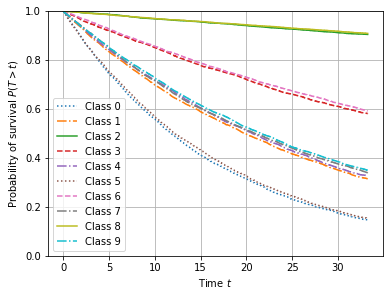

In [6]:
styles = ('-', '--', '-.', ':')

plt.figure(figsize=(6, 4.5))
for row in risk_score_assignment.itertuples():
    mask = y_train == row.Index
    coord_x, coord_y = kaplan_meier_estimator(event_train[mask], time_train[mask])
    ls = styles[row.risk_group]
    plt.step(coord_x, coord_y, where="post", label=f"Class {row.Index}", linestyle=ls)
plt.ylim(0, 1)
plt.ylabel("Probability of survival $P(T > t)$")
plt.xlabel("Time $t$")
plt.grid()
plt.legend()

Classes 0 and 5 (dotted lines) correspond to risk group 3, which has the highest risk score. The corresponding survival functions drop most quickly, which is exactly what we wanted. On the other end of the spectrum are classes 2 and 8 (solid lines) belonging to risk group 0 with the lowest risk.

## Evaluating Predictions

One important aspect for survival analysis is that both the training data and the test data are subject to censoring, because we are unable to observe the exact time of an event no matter how the data was split. Therefore, performance measures need to account for censoring. The most widely used performance measure is Harrell's concordance index. Given a set of (predicted) risk scores and observed times, it checks whether the ordering by risk scores is concordant with the ordering by actual survival time. While Harrell's concordance index is widely used, it has its flaws, in particular when data is highly censored. Please refer to my [previous post on evaluating survival models](https://k-d-w.org/blog/111/evaluating-survival-models) for more details.

We can take the risk score from which we generated survival times to check how good a model would perform if we knew the actual risk score.

In [7]:
cindex = concordance_index_censored(event_test, time_test, risk_scores[y_train.shape[0]:])

print(f"Concordance index on test data with actual risk scores: {cindex[0]:.3f}")

Concordance index on test data with actual risk scores: 0.705


Surprisingly, we do not obtain a perfect result of 1.0. The reason for this is that generated survival times are randomly distributed based on risk scores and not deterministic functions of the risk score. Therefore, any model we will train on this data should not be able to exceed this performance value.

## Cox's Proportional Hazards Model

By far the most widely used model to learn from censored survival data, is
[Cox's proportional hazards model](https://scholar.google.com/scholar?cluster=17981786408695305487) model.
It models the hazard function $h(t_i)$
of the $i$-th subject, conditional on the feature vector $\mathbf{x}_i \in \mathbb{R}^p$,
as the product of an unspecified baseline hazard function $h_0$ (more on that later) and an
exponential function of the linear model $\mathbf{x}_i^\top \mathbf{\beta}$:
$$
h(t | x_{i1}, \ldots, x_{ip}) = h_0(t) \exp \left( \sum_{j=1}^p x_{ij} \beta_j \right)
\Leftrightarrow
\log \frac{h(t | \mathbf{x}_i)}{h_0 (t)} =  \mathbf{x}_i^\top \mathbf{\beta} ,
$$
where $\mathbf{\beta} \in \mathbb{R}^p$ are the coefficients associated with each of the
$p$ features, and no intercept term is included in the model.
The key is that the hazard function is split into two parts: the baseline hazard function $h_0$ only depends on the time $t$, whereas the exponential is independent of time and only depends on the covariates $\mathbf{x}_i$.

Cox's proportional hazards model is fitted by maximizing the partial likelihood function, which is based on the probability that the $i$-th individual experiences
an event at time $t_i$, given that there is one event at time point $t_i$.
As we will see, by specifying the hazard function as above, the baseline hazard function $h_0$
can be eliminated and does not need be defined for finding the coefficients $\mathbf{\beta}$.
Let $\mathcal{R}_i = \{ j\,|\,y_j \geq y_i \}$
be the risk set, i.e., the set of subjects who remained event-free shortly before time point $y_i$,
and $I(\cdot)$ the indicator function, then we have

$$
\begin{split}
&P(\text{subject experiences event at $y_i$} \mid \text{one event at $y_i$}) \\
=& \frac{P(\text{subject experiences event at $y_i$} \mid \text{event-free up to $y_i$})}
{P (\text{one event at $y_i$} \mid \text{event-free up to $y_i$})} \\
=& \frac{h(y_i | \mathbf{x}_i)}{ \sum_{j=1}^n I(y_j \geq y_i) h(y_j | \mathbf{x}_j) } \\
=& \frac{h_0(y_i) \exp(\mathbf{x}_i^\top \mathbf{\beta})}
{ \sum_{j=1}^n I(y_j \geq y_i) h_0(y_j) \exp(\mathbf{x}_j^\top \mathbf{\beta}) } \\
=& \frac{\exp( \mathbf{x}_i^\top \beta)}{\sum_{j \in \mathcal{R}_i} \exp( \mathbf{x}_j^\top \beta)} .
\end{split}
$$

By multiplying the conditional probability from above for all patients who experienced an event, and taking the logarithm, we obtain the *partial likelihood function*:

$$
\widehat{\mathbf{\beta}} = \arg\max_{\mathbf{\beta}}~
\log\,PL(\mathbf{\beta}) = \sum_{i=1}^n \delta_i \left[ \mathbf{x}_i^\top \mathbf{\beta}
- \log \left( \sum_{j \in \mathcal{R}_i} \exp( \mathbf{x}_j^\top \mathbf{\beta}) \right) \right] .
$$


## Non-linear Survival Analysis with Neural Networks

Cox's proportional hazards model as described above is a linear model, i.e., the predicted risk score is a linear combination of features. However, the model can easily be extended to the non-linear case by just replacing the linear predictor with the output of a neural network with parameters $\mathbf{\Theta}$.

![image](data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%3F%3E%0A%3Csvg%20xmlns%3D%22http%3A//www.w3.org/2000/svg%22%20xmlns%3Axlink%3D%22http%3A//www.w3.org/1999/xlink%22%20width%3D%22323pt%22%20height%3D%22162pt%22%20viewBox%3D%220%200%20323%20162%22%20version%3D%221.1%22%3E%0A%3Cdefs%3E%0A%3Cg%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%207.109375%200%20L%207.109375%20-8.296875%20L%206.078125%20-8.296875%20L%206.078125%20-4.671875%20L%202.109375%20-4.671875%20L%202.109375%20-8.296875%20L%201.078125%20-8.296875%20L%201.078125%200%20L%202.109375%200%20L%202.109375%20-3.953125%20L%206.078125%20-3.953125%20L%206.078125%200%20Z%20M%207.109375%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%201.8125%200%20L%201.8125%20-5.3125%20L%200.9375%20-5.3125%20L%200.9375%200%20Z%20M%201.890625%20-6.796875%20L%201.890625%20-7.8125%20L%200.859375%20-7.8125%20L%200.859375%20-6.796875%20Z%20M%201.890625%20-6.796875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-3%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.0625%200%20L%205.0625%20-8.296875%20L%204.171875%20-8.296875%20L%204.171875%20-4.8125%20C%203.625%20-5.265625%203%20-5.421875%202.484375%20-5.421875%20C%201.34375%20-5.421875%200.421875%20-4.203125%200.421875%20-2.65625%20C%200.421875%20-1.109375%201.296875%200.125%202.4375%200.125%20C%202.875%200.125%203.546875%20-0.03125%204.140625%20-0.609375%20L%204.140625%200%20Z%20M%204.140625%20-1.40625%20C%203.859375%20-0.890625%203.4375%20-0.59375%202.921875%20-0.59375%20C%202.1875%20-0.59375%201.328125%20-1.15625%201.328125%20-2.640625%20C%201.328125%20-4.234375%202.34375%20-4.703125%203.03125%20-4.703125%20C%203.5%20-4.703125%203.890625%20-4.46875%204.140625%20-4.078125%20Z%20M%204.140625%20-1.40625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-4%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.859375%20-2.6875%20C%204.859375%20-3.203125%204.8125%20-3.9375%204.4375%20-4.5625%20C%203.9375%20-5.390625%203.109375%20-5.484375%202.765625%20-5.484375%20C%201.46875%20-5.484375%200.390625%20-4.25%200.390625%20-2.6875%20C%200.390625%20-1.109375%201.546875%200.125%202.921875%200.125%20C%203.484375%200.125%204.140625%20-0.03125%204.796875%20-0.515625%20C%204.796875%20-0.5625%204.75%20-0.953125%204.75%20-0.953125%20C%204.75%20-0.953125%204.71875%20-1.234375%204.71875%20-1.28125%20C%204.015625%20-0.6875%203.3125%20-0.59375%202.953125%20-0.59375%20C%202.03125%20-0.59375%201.25%20-1.421875%201.21875%20-2.6875%20Z%20M%204.15625%20-3.328125%20L%201.296875%20-3.328125%20C%201.5%20-4.140625%202.0625%20-4.765625%202.765625%20-4.765625%20C%203.125%20-4.765625%203.953125%20-4.609375%204.15625%20-3.328125%20Z%20M%204.15625%20-3.328125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-5%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.0625%200%20L%205.0625%20-3.59375%20C%205.0625%20-4.328125%204.90625%20-5.421875%203.46875%20-5.421875%20C%202.796875%20-5.421875%202.21875%20-5.125%201.765625%20-4.546875%20L%201.765625%20-5.359375%20L%200.921875%20-5.359375%20L%200.921875%200%20L%201.828125%200%20L%201.828125%20-2.96875%20C%201.828125%20-3.71875%202.109375%20-4.703125%203.015625%20-4.703125%20C%204.125%20-4.703125%204.15625%20-3.9375%204.15625%20-3.515625%20L%204.15625%200%20Z%20M%205.0625%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-6%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%201.8125%200%20L%201.8125%20-8.296875%20L%200.9375%20-8.296875%20L%200.9375%200%20Z%20M%201.8125%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-7%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.796875%200%20L%204.796875%20-3.5%20C%204.796875%20-4.65625%203.96875%20-5.484375%202.859375%20-5.484375%20C%202.140625%20-5.484375%201.609375%20-5.3125%201.015625%20-4.984375%20L%201.09375%20-4.203125%20C%201.609375%20-4.578125%202.15625%20-4.796875%202.859375%20-4.796875%20C%203.40625%20-4.796875%203.890625%20-4.34375%203.890625%20-3.484375%20L%203.890625%20-2.984375%20C%203.34375%20-2.96875%202.625%20-2.921875%201.90625%20-2.6875%20C%201.109375%20-2.421875%200.640625%20-1.96875%200.640625%20-1.375%20C%200.640625%20-0.84375%200.953125%200.125%201.96875%200.125%20C%202.625%200.125%203.46875%20-0.078125%203.90625%20-0.4375%20L%203.90625%200%20Z%20M%203.890625%20-1.609375%20C%203.890625%20-1.359375%203.890625%20-1.078125%203.484375%20-0.84375%20C%203.171875%20-0.640625%202.765625%20-0.59375%202.578125%20-0.59375%20C%201.9375%20-0.59375%201.5%20-0.9375%201.5%20-1.390625%20C%201.5%20-2.203125%203.15625%20-2.375%203.890625%20-2.375%20Z%20M%203.890625%20-1.609375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-8%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.171875%20-5.3125%20L%204.28125%20-5.3125%20C%203.734375%20-3.890625%202.8125%20-1.546875%202.765625%20-0.6875%20L%202.75%20-0.6875%20C%202.6875%20-1.40625%202.0625%20-2.96875%201.953125%20-3.21875%20L%201.109375%20-5.3125%20L%200.171875%20-5.3125%20L%202.390625%200%20L%201.96875%201.09375%20C%201.703125%201.6875%201.53125%201.75%201.3125%201.75%20C%201.140625%201.75%200.765625%201.703125%200.390625%201.5625%20L%200.46875%202.34375%20C%200.53125%202.359375%200.9375%202.4375%201.3125%202.4375%20C%201.609375%202.4375%202.15625%202.4375%202.671875%201.125%20Z%20M%205.171875%20-5.3125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-9%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.796875%20-4.625%20L%203.796875%20-5.421875%20C%202.71875%20-5.421875%202.078125%20-4.78125%201.75%20-4.3125%20L%201.75%20-5.359375%20L%200.9375%20-5.359375%20L%200.9375%200%20L%201.8125%200%20L%201.8125%20-2.625%20C%201.8125%20-3.828125%202.71875%20-4.609375%203.796875%20-4.625%20Z%20M%203.796875%20-4.625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-10%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%202.109375%200%20L%202.109375%20-8.296875%20L%201.078125%20-8.296875%20L%201.078125%200%20Z%20M%202.109375%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-11%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.5625%20-2.671875%20C%205.5625%20-4.109375%204.8125%20-5.421875%203.6875%20-5.421875%20C%203.203125%20-5.421875%202.4375%20-5.265625%201.8125%20-4.75%20L%201.8125%20-5.3125%20L%200.9375%20-5.3125%20L%200.9375%202.3125%20L%201.84375%202.3125%20L%201.84375%20-0.53125%20C%202.25%20-0.171875%202.75%200.125%203.390625%200.125%20C%204.546875%200.125%205.5625%20-1.046875%205.5625%20-2.671875%20Z%20M%204.65625%20-2.65625%20C%204.65625%20-1.453125%203.84375%20-0.59375%202.953125%20-0.59375%20C%202.625%20-0.59375%202.390625%20-0.71875%202.171875%20-0.890625%20C%201.875%20-1.140625%201.84375%20-1.359375%201.84375%20-1.546875%20L%201.84375%20-4.015625%20C%202.109375%20-4.421875%202.5625%20-4.6875%203.0625%20-4.6875%20C%203.9375%20-4.6875%204.65625%20-3.796875%204.65625%20-2.65625%20Z%20M%204.65625%20-2.65625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-12%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.0625%200%20L%205.0625%20-5.3125%20L%204.15625%20-5.3125%20L%204.15625%20-1.890625%20C%204.15625%20-0.984375%203.53125%20-0.53125%202.75%20-0.53125%20C%201.90625%20-0.53125%201.828125%20-0.84375%201.828125%20-1.375%20L%201.828125%20-5.3125%20L%200.921875%20-5.3125%20L%200.921875%20-1.328125%20C%200.921875%20-0.46875%201.1875%200.125%202.171875%200.125%20C%202.515625%200.125%203.453125%200.0625%204.1875%20-0.59375%20L%204.1875%200%20Z%20M%205.0625%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-13%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.890625%20-0.34375%20L%203.71875%20-1.046875%20C%203.296875%20-0.671875%202.859375%20-0.625%202.640625%20-0.625%20C%202.109375%20-0.625%202.046875%20-1.1875%202.046875%20-1.609375%20L%202.046875%20-4.609375%20L%203.6875%20-4.609375%20L%203.6875%20-5.3125%20L%202.046875%20-5.3125%20L%202.046875%20-6.828125%20L%201.21875%20-6.828125%20L%201.21875%20-5.3125%20L%200.21875%20-5.3125%20L%200.21875%20-4.609375%20L%201.1875%20-4.609375%20L%201.1875%20-1.40625%20C%201.1875%20-0.703125%201.34375%200.125%202.171875%200.125%20C%202.96875%200.125%203.53125%20-0.15625%203.890625%20-0.34375%20Z%20M%203.890625%20-0.34375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-14%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%207.96875%20-4.125%20C%207.96875%20-6.65625%206.25%20-8.546875%204.3125%20-8.546875%20C%202.328125%20-8.546875%200.640625%20-6.625%200.640625%20-4.125%20C%200.640625%20-1.609375%202.375%200.25%204.296875%200.25%20C%206.28125%200.25%207.96875%20-1.625%207.96875%20-4.125%20Z%20M%206.9375%20-4.296875%20C%206.9375%20-1.953125%205.65625%20-0.5%204.3125%20-0.5%20C%202.921875%20-0.5%201.671875%20-2%201.671875%20-4.296875%20C%201.671875%20-6.5%202.96875%20-7.8125%204.296875%20-7.8125%20C%205.671875%20-7.8125%206.9375%20-6.46875%206.9375%20-4.296875%20Z%20M%206.9375%20-4.296875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-15%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.875%20-0.53125%20L%206.796875%20-1.375%20C%206.484375%20-1.140625%206.125%20-0.890625%205.734375%20-0.765625%20C%205.359375%20-0.640625%204.953125%20-0.625%204.546875%20-0.625%20C%203.78125%20-0.625%203.078125%20-1.046875%202.609375%20-1.65625%20C%202.0625%20-2.359375%201.8125%20-3.25%201.8125%20-4.140625%20C%201.8125%20-5.046875%202.0625%20-5.9375%202.609375%20-6.640625%20C%203.078125%20-7.25%203.78125%20-7.671875%204.546875%20-7.671875%20C%204.90625%20-7.671875%205.265625%20-7.640625%205.609375%20-7.53125%20C%205.953125%20-7.40625%206.28125%20-7.234375%206.578125%20-7.015625%20L%206.75%20-8.015625%20C%206.390625%20-8.15625%206.03125%20-8.265625%205.671875%20-8.328125%20C%205.296875%20-8.40625%204.90625%20-8.421875%204.546875%20-8.421875%20C%203.515625%20-8.421875%202.5625%20-7.953125%201.890625%20-7.171875%20C%201.140625%20-6.34375%200.78125%20-5.265625%200.78125%20-4.140625%20C%200.78125%20-3.046875%201.140625%20-1.953125%201.890625%20-1.125%20C%202.5625%20-0.359375%203.515625%200.125%204.546875%200.125%20C%204.953125%200.125%205.359375%200.109375%205.765625%200%20C%206.171875%20-0.125%206.53125%20-0.328125%206.875%20-0.53125%20Z%20M%206.875%20-0.53125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-16%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.484375%20-2.625%20C%205.484375%20-4.25%204.296875%20-5.484375%202.921875%20-5.484375%20C%201.515625%20-5.484375%200.359375%20-4.21875%200.359375%20-2.625%20C%200.359375%20-1.0625%201.546875%200.125%202.921875%200.125%20C%204.328125%200.125%205.484375%20-1.09375%205.484375%20-2.625%20Z%20M%204.578125%20-2.75%20C%204.578125%20-1.28125%203.734375%20-0.625%202.921875%20-0.625%20C%202.0625%20-0.625%201.265625%20-1.34375%201.265625%20-2.75%20C%201.265625%20-4.203125%202.15625%20-4.765625%202.921875%20-4.765625%20C%203.734375%20-4.765625%204.578125%20-4.140625%204.578125%20-2.75%20Z%20M%204.578125%20-2.75%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-17%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.34375%200%20L%203.03125%20-2.734375%20L%205.15625%20-5.3125%20L%204.140625%20-5.3125%20L%202.640625%20-3.375%20L%201.078125%20-5.3125%20L%200.0625%20-5.3125%20L%202.234375%20-2.734375%20L%200%200%20L%200.984375%200%20L%202.640625%20-2.21875%20L%204.34375%200%20Z%20M%205.34375%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-18%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.796875%20-5.875%20C%206.796875%20-7.140625%205.625%20-8.296875%204%20-8.296875%20L%201.09375%20-8.296875%20L%201.09375%200%20L%202.109375%200%20L%202.109375%20-3.453125%20L%204%20-3.453125%20C%205.65625%20-3.453125%206.796875%20-4.640625%206.796875%20-5.875%20Z%20M%205.84375%20-5.890625%20C%205.84375%20-4.953125%205.109375%20-4.140625%203.75%20-4.140625%20L%202.09375%20-4.140625%20L%202.09375%20-7.625%20L%203.75%20-7.625%20C%205.15625%20-7.625%205.84375%20-6.796875%205.84375%20-5.890625%20Z%20M%205.84375%20-5.890625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-19%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.203125%20-1.515625%20C%204.203125%20-2.125%203.84375%20-2.515625%203.796875%20-2.5625%20C%203.34375%20-3.03125%202.984375%20-3.09375%202.265625%20-3.234375%20C%201.828125%20-3.328125%201.21875%20-3.4375%201.21875%20-4.046875%20C%201.21875%20-4.78125%202.0625%20-4.78125%202.21875%20-4.78125%20C%202.84375%20-4.78125%203.34375%20-4.640625%203.875%20-4.34375%20L%204.015625%20-5.109375%20C%203.25%20-5.46875%202.609375%20-5.484375%202.328125%20-5.484375%20C%202.0625%20-5.484375%200.390625%20-5.484375%200.390625%20-3.9375%20C%200.390625%20-3.40625%200.6875%20-3.046875%200.859375%20-2.875%20C%201.296875%20-2.515625%201.59375%20-2.453125%202.296875%20-2.3125%20C%202.6875%20-2.21875%203.375%20-2.078125%203.375%20-1.453125%20C%203.375%20-0.625%202.453125%20-0.625%202.28125%20-0.625%20C%201.8125%20-0.625%201.109375%20-0.75%200.46875%20-1.21875%20L%200.328125%20-0.40625%20C%200.375%20-0.375%201.1875%200.125%202.296875%200.125%20C%203.84375%200.125%204.203125%20-0.8125%204.203125%20-1.515625%20Z%20M%204.203125%20-1.515625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.671875%20-1.0625%20L%205.671875%20-1.734375%20L%205.40625%20-1.734375%20L%205.40625%20-1.0625%20C%205.40625%20-0.375%205.109375%20-0.28125%204.953125%20-0.28125%20C%204.5%20-0.28125%204.5%20-0.921875%204.5%20-1.09375%20L%204.5%20-3.1875%20C%204.5%20-3.84375%204.5%20-4.3125%203.96875%20-4.78125%20C%203.546875%20-5.15625%203.015625%20-5.328125%202.484375%20-5.328125%20C%201.5%20-5.328125%200.75%20-4.6875%200.75%20-3.90625%20C%200.75%20-3.5625%200.984375%20-3.390625%201.25%20-3.390625%20C%201.546875%20-3.390625%201.75%20-3.59375%201.75%20-3.890625%20C%201.75%20-4.375%201.3125%20-4.375%201.140625%20-4.375%20C%201.40625%20-4.875%201.984375%20-5.09375%202.46875%20-5.09375%20C%203.015625%20-5.09375%203.71875%20-4.640625%203.71875%20-3.5625%20L%203.71875%20-3.078125%20C%201.3125%20-3.046875%200.40625%20-2.046875%200.40625%20-1.125%20C%200.40625%20-0.171875%201.5%200.125%202.234375%200.125%20C%203.03125%200.125%203.5625%20-0.359375%203.796875%20-0.9375%20C%203.84375%20-0.375%204.203125%200.0625%204.71875%200.0625%20C%204.96875%200.0625%205.671875%20-0.109375%205.671875%20-1.0625%20Z%20M%203.71875%20-1.6875%20C%203.71875%20-0.515625%202.84375%20-0.125%202.328125%20-0.125%20C%201.75%20-0.125%201.25%20-0.546875%201.25%20-1.125%20C%201.25%20-2.703125%203.28125%20-2.84375%203.71875%20-2.875%20Z%20M%203.71875%20-1.6875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.21875%20-4.578125%20C%204.21875%20-4.9375%203.890625%20-5.265625%203.375%20-5.265625%20C%202.359375%20-5.265625%202.015625%20-4.171875%201.953125%20-3.9375%20L%201.9375%20-3.9375%20L%201.9375%20-5.265625%20L%200.328125%20-5.140625%20L%200.328125%20-4.796875%20C%201.140625%20-4.796875%201.25%20-4.703125%201.25%20-4.125%20L%201.25%20-0.890625%20C%201.25%20-0.34375%201.109375%20-0.34375%200.328125%20-0.34375%20L%200.328125%200%20C%200.671875%20-0.03125%201.328125%20-0.03125%201.6875%20-0.03125%20C%202.015625%20-0.03125%202.859375%20-0.03125%203.125%200%20L%203.125%20-0.34375%20L%202.890625%20-0.34375%20C%202.015625%20-0.34375%202%20-0.484375%202%20-0.90625%20L%202%20-2.78125%20C%202%20-3.9375%202.46875%20-5.03125%203.390625%20-5.03125%20C%203.484375%20-5.03125%203.515625%20-5.03125%203.5625%20-5.015625%20C%203.46875%20-4.96875%203.28125%20-4.90625%203.28125%20-4.578125%20C%203.28125%20-4.234375%203.546875%20-4.09375%203.734375%20-4.09375%20C%203.984375%20-4.09375%204.21875%20-4.25%204.21875%20-4.578125%20Z%20M%204.21875%20-4.578125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-3%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.671875%20-4.859375%20C%205.671875%20-5.0625%205.515625%20-5.40625%205.09375%20-5.40625%20C%204.46875%20-5.40625%204%20-5.015625%203.84375%20-4.84375%20C%203.484375%20-5.109375%203.0625%20-5.265625%202.609375%20-5.265625%20C%201.53125%20-5.265625%200.734375%20-4.453125%200.734375%20-3.53125%20C%200.734375%20-2.859375%201.140625%20-2.421875%201.265625%20-2.3125%20C%201.125%20-2.125%200.90625%20-1.78125%200.90625%20-1.3125%20C%200.90625%20-0.625%201.328125%20-0.328125%201.421875%20-0.265625%20C%200.875%20-0.109375%200.328125%200.328125%200.328125%200.9375%20C%200.328125%201.765625%201.453125%202.453125%202.921875%202.453125%20C%204.34375%202.453125%205.515625%201.8125%205.515625%200.921875%20C%205.515625%200.625%205.4375%20-0.078125%204.71875%20-0.453125%20C%204.109375%20-0.765625%203.515625%20-0.765625%202.484375%20-0.765625%20C%201.75%20-0.765625%201.671875%20-0.765625%201.453125%20-0.984375%20C%201.34375%20-1.109375%201.234375%20-1.34375%201.234375%20-1.59375%20C%201.234375%20-1.796875%201.296875%20-2%201.421875%20-2.15625%20C%201.984375%20-1.796875%202.46875%20-1.796875%202.59375%20-1.796875%20C%203.671875%20-1.796875%204.46875%20-2.609375%204.46875%20-3.53125%20C%204.46875%20-3.84375%204.375%20-4.296875%204%20-4.6875%20C%204.453125%20-5.15625%205.015625%20-5.15625%205.078125%20-5.15625%20C%205.125%20-5.15625%205.1875%20-5.15625%205.234375%20-5.140625%20C%205.109375%20-5.09375%205.0625%20-4.96875%205.0625%20-4.84375%20C%205.0625%20-4.671875%205.171875%20-4.53125%205.359375%20-4.53125%20C%205.46875%20-4.53125%205.671875%20-4.59375%205.671875%20-4.859375%20Z%20M%203.640625%20-3.53125%20C%203.640625%20-3.328125%203.640625%20-2.828125%203.4375%20-2.515625%20C%203.21875%20-2.15625%202.859375%20-2.046875%202.609375%20-2.046875%20C%201.546875%20-2.046875%201.546875%20-3.25%201.546875%20-3.53125%20C%201.546875%20-3.734375%201.546875%20-4.234375%201.75%20-4.546875%20C%201.984375%20-4.90625%202.34375%20-5.015625%202.59375%20-5.015625%20C%203.640625%20-5.015625%203.640625%20-3.8125%203.640625%20-3.53125%20Z%20M%204.9375%200.9375%20C%204.9375%201.640625%204.03125%202.203125%202.921875%202.203125%20C%201.78125%202.203125%200.90625%201.609375%200.90625%200.9375%20C%200.90625%200.84375%200.9375%200.375%201.390625%200.0625%20C%201.65625%20-0.109375%201.75%20-0.109375%202.59375%20-0.109375%20C%203.578125%20-0.109375%204.9375%20-0.109375%204.9375%200.9375%20Z%20M%204.9375%200.9375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-4%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%209.484375%200%20L%209.484375%20-0.34375%20C%208.875%20-0.34375%208.578125%20-0.34375%208.578125%20-0.703125%20L%208.578125%20-2.90625%20C%208.578125%20-4.015625%208.578125%20-4.34375%208.296875%20-4.734375%20C%207.953125%20-5.203125%207.390625%20-5.265625%206.984375%20-5.265625%20C%205.984375%20-5.265625%205.484375%20-4.546875%205.296875%20-4.09375%20C%205.125%20-5.015625%204.484375%20-5.265625%203.734375%20-5.265625%20C%202.5625%20-5.265625%202.109375%20-4.28125%202.015625%20-4.046875%20L%202.015625%20-5.265625%20L%200.375%20-5.140625%20L%200.375%20-4.796875%20C%201.1875%20-4.796875%201.296875%20-4.703125%201.296875%20-4.125%20L%201.296875%20-0.890625%20C%201.296875%20-0.34375%201.15625%20-0.34375%200.375%20-0.34375%20L%200.375%200%20C%200.6875%20-0.03125%201.34375%20-0.03125%201.671875%20-0.03125%20C%202.015625%20-0.03125%202.671875%20-0.03125%202.96875%200%20L%202.96875%20-0.34375%20C%202.21875%20-0.34375%202.0625%20-0.34375%202.0625%20-0.890625%20L%202.0625%20-3.109375%20C%202.0625%20-4.359375%202.890625%20-5.03125%203.640625%20-5.03125%20C%204.375%20-5.03125%204.546875%20-4.421875%204.546875%20-3.6875%20L%204.546875%20-0.890625%20C%204.546875%20-0.34375%204.40625%20-0.34375%203.640625%20-0.34375%20L%203.640625%200%20C%203.9375%20-0.03125%204.59375%20-0.03125%204.921875%20-0.03125%20C%205.265625%20-0.03125%205.921875%20-0.03125%206.234375%200%20L%206.234375%20-0.34375%20C%205.46875%20-0.34375%205.3125%20-0.34375%205.3125%20-0.890625%20L%205.3125%20-3.109375%20C%205.3125%20-4.359375%206.140625%20-5.03125%206.890625%20-5.03125%20C%207.625%20-5.03125%207.796875%20-4.421875%207.796875%20-3.6875%20L%207.796875%20-0.890625%20C%207.796875%20-0.34375%207.65625%20-0.34375%206.890625%20-0.34375%20L%206.890625%200%20C%207.203125%20-0.03125%207.84375%20-0.03125%208.171875%20-0.03125%20C%208.515625%20-0.03125%209.171875%20-0.03125%209.484375%200%20Z%20M%209.484375%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-5%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.046875%200%20L%206.046875%20-0.34375%20C%205.421875%20-0.34375%205.203125%20-0.375%204.90625%20-0.75%20L%203.34375%20-2.828125%20C%203.6875%20-3.28125%204.203125%20-3.921875%204.421875%20-4.171875%20C%204.90625%20-4.71875%205.46875%20-4.8125%205.859375%20-4.8125%20L%205.859375%20-5.15625%20C%205.34375%20-5.125%205.3125%20-5.125%204.859375%20-5.125%20L%203.78125%20-5.15625%20L%203.78125%20-4.8125%20C%203.9375%20-4.78125%204.125%20-4.703125%204.125%20-4.4375%20C%204.125%20-4.234375%204.015625%20-4.09375%203.9375%20-4%20L%203.171875%20-3.03125%20L%202.25%20-4.265625%20C%202.21875%20-4.3125%202.140625%20-4.421875%202.140625%20-4.5%20C%202.140625%20-4.578125%202.203125%20-4.796875%202.5625%20-4.8125%20L%202.5625%20-5.15625%20C%202.265625%20-5.125%201.65625%20-5.125%201.328125%20-5.125%20L%200.171875%20-5.15625%20L%200.171875%20-4.8125%20C%200.78125%20-4.8125%201.015625%20-4.78125%201.265625%20-4.453125%20L%202.671875%20-2.625%20C%202.6875%20-2.609375%202.734375%20-2.53125%202.734375%20-2.5%20C%202.734375%20-2.46875%201.8125%20-1.296875%201.6875%20-1.140625%20C%201.15625%20-0.484375%200.640625%20-0.359375%200.125%20-0.34375%20L%200.125%200%20C%200.578125%20-0.03125%200.59375%20-0.03125%201.109375%20-0.03125%20L%202.1875%200%20L%202.1875%20-0.34375%20C%201.90625%20-0.375%201.859375%20-0.5625%201.859375%20-0.734375%20C%201.859375%20-0.921875%201.9375%20-1.015625%202.0625%20-1.171875%20L%202.921875%20-2.28125%20L%203.890625%20-1%20C%204.09375%20-0.734375%204.09375%20-0.71875%204.09375%20-0.640625%20C%204.09375%20-0.546875%204%20-0.359375%203.6875%20-0.34375%20L%203.6875%200%20C%204%20-0.03125%204.578125%20-0.03125%204.90625%20-0.03125%20Z%20M%206.046875%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-6%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.890625%202.90625%20C%203.890625%202.875%203.890625%202.84375%203.6875%202.640625%20C%202.484375%201.4375%201.8125%20-0.53125%201.8125%20-2.96875%20C%201.8125%20-5.296875%202.375%20-7.296875%203.765625%20-8.703125%20C%203.890625%20-8.8125%203.890625%20-8.828125%203.890625%20-8.875%20C%203.890625%20-8.9375%203.828125%20-8.96875%203.78125%20-8.96875%20C%203.625%20-8.96875%202.640625%20-8.109375%202.0625%20-6.9375%20C%201.453125%20-5.71875%201.171875%20-4.453125%201.171875%20-2.96875%20C%201.171875%20-1.90625%201.34375%20-0.484375%201.953125%200.78125%20C%202.671875%202.21875%203.640625%203%203.78125%203%20C%203.828125%203%203.890625%202.96875%203.890625%202.90625%20Z%20M%203.890625%202.90625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-7%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.375%20-2.96875%20C%203.375%20-3.890625%203.25%20-5.359375%202.578125%20-6.75%20C%201.875%20-8.1875%200.890625%20-8.96875%200.765625%20-8.96875%20C%200.71875%20-8.96875%200.65625%20-8.9375%200.65625%20-8.875%20C%200.65625%20-8.828125%200.65625%20-8.8125%200.859375%20-8.609375%20C%202.0625%20-7.40625%202.71875%20-5.421875%202.71875%20-2.984375%20C%202.71875%20-0.671875%202.15625%201.328125%200.78125%202.734375%20C%200.65625%202.84375%200.65625%202.875%200.65625%202.90625%20C%200.65625%202.96875%200.71875%203%200.765625%203%20C%200.921875%203%201.90625%202.140625%202.484375%200.96875%20C%203.09375%20-0.25%203.375%20-1.546875%203.375%20-2.96875%20Z%20M%203.375%20-2.96875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-8%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%202.96875%200%20L%202.96875%20-0.34375%20C%202.203125%20-0.34375%202.0625%20-0.34375%202.0625%20-0.890625%20L%202.0625%20-8.296875%20L%200.390625%20-8.15625%20L%200.390625%20-7.8125%20C%201.203125%20-7.8125%201.296875%20-7.734375%201.296875%20-7.140625%20L%201.296875%20-0.890625%20C%201.296875%20-0.34375%201.171875%20-0.34375%200.390625%20-0.34375%20L%200.390625%200%20C%200.734375%20-0.03125%201.3125%20-0.03125%201.671875%20-0.03125%20C%202.03125%20-0.03125%202.625%20-0.03125%202.96875%200%20Z%20M%202.96875%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-9%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.484375%20-2.5625%20C%205.484375%20-4.09375%204.3125%20-5.328125%202.921875%20-5.328125%20C%201.5%20-5.328125%200.359375%20-4.0625%200.359375%20-2.5625%20C%200.359375%20-1.03125%201.546875%200.125%202.921875%200.125%20C%204.328125%200.125%205.484375%20-1.046875%205.484375%20-2.5625%20Z%20M%204.578125%20-2.671875%20C%204.578125%20-2.25%204.578125%20-1.5%204.265625%20-0.9375%20C%203.9375%20-0.375%203.375%20-0.140625%202.921875%20-0.140625%20C%202.484375%20-0.140625%201.953125%20-0.328125%201.609375%20-0.921875%20C%201.28125%20-1.453125%201.265625%20-2.15625%201.265625%20-2.671875%20C%201.265625%20-3.125%201.265625%20-3.84375%201.640625%20-4.390625%20C%201.96875%20-4.90625%202.5%20-5.09375%202.921875%20-5.09375%20C%203.375%20-5.09375%203.890625%20-4.875%204.203125%20-4.40625%20C%204.578125%20-3.859375%204.578125%20-3.109375%204.578125%20-2.671875%20Z%20M%204.578125%20-2.671875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-10%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.859375%20-1.421875%20C%204.859375%20-1.5%204.8125%20-1.546875%204.734375%20-1.546875%20C%204.640625%20-1.546875%204.609375%20-1.484375%204.59375%20-1.421875%20C%204.28125%20-0.421875%203.484375%20-0.140625%202.96875%20-0.140625%20C%202.46875%20-0.140625%201.265625%20-0.484375%201.265625%20-2.546875%20L%201.265625%20-2.765625%20L%204.578125%20-2.765625%20C%204.84375%20-2.765625%204.859375%20-2.765625%204.859375%20-3%20C%204.859375%20-4.203125%204.21875%20-5.328125%202.765625%20-5.328125%20C%201.40625%20-5.328125%200.359375%20-4.09375%200.359375%20-2.625%20C%200.359375%20-1.046875%201.578125%200.125%202.90625%200.125%20C%204.328125%200.125%204.859375%20-1.171875%204.859375%20-1.421875%20Z%20M%204.125%20-3%20L%201.28125%20-3%20C%201.375%20-4.875%202.421875%20-5.09375%202.765625%20-5.09375%20C%204.046875%20-5.09375%204.109375%20-3.40625%204.125%20-3%20Z%20M%204.125%20-3%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-11%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.078125%20-2.578125%20C%206.078125%20-4.09375%204.953125%20-5.265625%203.640625%20-5.265625%20C%202.59375%20-5.265625%202.03125%20-4.515625%202%20-4.46875%20L%202%20-5.265625%20L%200.328125%20-5.140625%20L%200.328125%20-4.796875%20C%201.171875%20-4.796875%201.25%20-4.703125%201.25%20-4.1875%20L%201.25%201.4375%20C%201.25%201.96875%201.109375%201.96875%200.328125%201.96875%20L%200.328125%202.3125%20C%200.640625%202.296875%201.296875%202.296875%201.625%202.296875%20C%201.96875%202.296875%202.625%202.296875%202.921875%202.3125%20L%202.921875%201.96875%20C%202.15625%201.96875%202.015625%201.96875%202.015625%201.4375%20L%202.015625%20-0.640625%20C%202.234375%20-0.34375%202.71875%200.125%203.484375%200.125%20C%204.859375%200.125%206.078125%20-1.046875%206.078125%20-2.578125%20Z%20M%205.15625%20-2.578125%20C%205.15625%20-1.15625%204.34375%20-0.125%203.4375%20-0.125%20C%203.0625%20-0.125%202.71875%20-0.28125%202.46875%20-0.5%20C%202.203125%20-0.78125%202.015625%20-1.015625%202.015625%20-1.34375%20L%202.015625%20-3.8125%20C%202.015625%20-4.046875%202.015625%20-4.046875%202.15625%20-4.25%20C%202.515625%20-4.78125%203.09375%20-5.015625%203.546875%20-5.015625%20C%204.453125%20-5.015625%205.15625%20-3.921875%205.15625%20-2.578125%20Z%20M%205.15625%20-2.578125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%207.046875%20-2.703125%20C%207.046875%20-4.265625%205.953125%20-5.578125%203.796875%20-5.578125%20C%201.625%20-5.578125%200.546875%20-4.25%200.546875%20-2.703125%20C%200.546875%20-1.15625%201.640625%200.109375%203.796875%200.109375%20C%205.9375%200.109375%207.046875%20-1.15625%207.046875%20-2.703125%20Z%20M%205.875%20-2.703125%20C%205.875%20-1.859375%205.71875%20-1.34375%205.390625%20-0.921875%20C%205.078125%20-0.53125%204.515625%20-0.234375%203.796875%20-0.234375%20C%203.0625%20-0.234375%202.515625%20-0.53125%202.21875%20-0.90625%20C%201.875%20-1.328125%201.71875%20-1.859375%201.71875%20-2.703125%20C%201.71875%20-3.015625%201.71875%20-3.875%202.15625%20-4.484375%20C%202.625%20-5.09375%203.296875%20-5.25%203.796875%20-5.25%20C%204.25%20-5.25%204.96875%20-5.109375%205.453125%20-4.453125%20C%205.84375%20-3.875%205.875%20-3.078125%205.875%20-2.703125%20Z%20M%205.328125%20-1.953125%20L%205.328125%20-3.515625%20L%204.875%20-3.515625%20L%204.875%20-3.25%20L%202.703125%20-3.25%20L%202.703125%20-3.515625%20L%202.265625%20-3.515625%20L%202.265625%20-1.953125%20L%202.703125%20-1.953125%20L%202.703125%20-2.234375%20L%204.875%20-2.234375%20L%204.875%20-1.953125%20Z%20M%205.328125%20-1.953125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph3-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph3-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.875%20-1.140625%20C%204.875%20-1.21875%204.8125%20-1.25%204.75%20-1.25%20C%204.65625%20-1.25%204.640625%20-1.1875%204.625%20-1.109375%20C%204.4375%20-0.453125%204.09375%20-0.140625%203.796875%20-0.140625%20C%203.671875%20-0.140625%203.609375%20-0.21875%203.609375%20-0.40625%20C%203.609375%20-0.59375%203.671875%20-0.765625%203.75%20-0.96875%20C%203.859375%20-1.265625%204.21875%20-2.1875%204.21875%20-2.625%20C%204.21875%20-3.234375%203.796875%20-3.515625%203.234375%20-3.515625%20C%202.578125%20-3.515625%202.171875%20-3.125%201.9375%20-2.828125%20C%201.875%20-3.265625%201.53125%20-3.515625%201.125%20-3.515625%20C%200.84375%20-3.515625%200.640625%20-3.328125%200.515625%20-3.078125%20C%200.3125%20-2.703125%200.234375%20-2.296875%200.234375%20-2.296875%20C%200.234375%20-2.21875%200.296875%20-2.1875%200.359375%20-2.1875%20C%200.46875%20-2.1875%200.46875%20-2.21875%200.53125%20-2.4375%20C%200.625%20-2.828125%200.765625%20-3.296875%201.09375%20-3.296875%20C%201.3125%20-3.296875%201.359375%20-3.09375%201.359375%20-2.921875%20C%201.359375%20-2.765625%201.3125%20-2.625%201.25%20-2.359375%20L%201.078125%20-1.71875%20L%200.78125%20-0.515625%20C%200.75%20-0.390625%200.703125%20-0.203125%200.703125%20-0.171875%20C%200.703125%200.015625%200.859375%200.078125%200.96875%200.078125%20C%201.109375%200.078125%201.234375%20-0.015625%201.28125%20-0.109375%20C%201.3125%20-0.15625%201.375%20-0.4375%201.40625%20-0.59375%20L%201.59375%20-1.3125%20C%201.625%20-1.421875%201.703125%20-1.734375%201.71875%20-1.84375%20C%201.828125%20-2.28125%201.828125%20-2.28125%202.015625%20-2.546875%20C%202.28125%20-2.9375%202.65625%20-3.296875%203.1875%20-3.296875%20C%203.46875%20-3.296875%203.640625%20-3.125%203.640625%20-2.75%20C%203.640625%20-2.3125%203.3125%20-1.40625%203.15625%20-1.015625%20C%203.046875%20-0.75%203.046875%20-0.703125%203.046875%20-0.59375%20C%203.046875%20-0.140625%203.421875%200.078125%203.765625%200.078125%20C%204.546875%200.078125%204.875%20-1.03125%204.875%20-1.140625%20Z%20M%204.875%20-1.140625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph3-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%202.375%20-4.96875%20C%202.375%20-5.140625%202.25%20-5.28125%202.0625%20-5.28125%20C%201.859375%20-5.28125%201.625%20-5.078125%201.625%20-4.84375%20C%201.625%20-4.671875%201.75%20-4.546875%201.9375%20-4.546875%20C%202.140625%20-4.546875%202.375%20-4.734375%202.375%20-4.96875%20Z%20M%202.53125%20-1.140625%20C%202.53125%20-1.21875%202.46875%20-1.25%202.40625%20-1.25%20C%202.3125%20-1.25%202.296875%20-1.1875%202.265625%20-1.109375%20C%202.09375%20-0.46875%201.765625%20-0.140625%201.4375%20-0.140625%20C%201.34375%20-0.140625%201.25%20-0.1875%201.25%20-0.390625%20C%201.25%20-0.59375%201.3125%20-0.734375%201.40625%20-0.984375%20L%201.90625%20-2.265625%20C%201.96875%20-2.453125%202.078125%20-2.703125%202.078125%20-2.84375%20C%202.078125%20-3.234375%201.75%20-3.515625%201.34375%20-3.515625%20C%200.578125%20-3.515625%200.234375%20-2.40625%200.234375%20-2.296875%20C%200.234375%20-2.21875%200.296875%20-2.1875%200.359375%20-2.1875%20C%200.46875%20-2.1875%200.46875%20-2.234375%200.5%20-2.3125%20C%200.71875%20-3.078125%201.078125%20-3.296875%201.328125%20-3.296875%20C%201.4375%20-3.296875%201.515625%20-3.25%201.515625%20-3.03125%20C%201.515625%20-2.953125%201.5%20-2.84375%201.421875%20-2.59375%20L%201.21875%20-2.046875%20C%201%20-1.515625%201%20-1.5%200.78125%20-0.953125%20C%200.734375%20-0.828125%200.703125%20-0.734375%200.703125%20-0.59375%20C%200.703125%20-0.203125%201%200.078125%201.421875%200.078125%20C%202.203125%200.078125%202.53125%20-1.03125%202.53125%20-1.140625%20Z%20M%202.53125%20-1.140625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph3-3%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.296875%20-4.96875%20C%203.296875%20-5.125%203.171875%20-5.28125%202.984375%20-5.28125%20C%202.734375%20-5.28125%202.53125%20-5.046875%202.53125%20-4.84375%20C%202.53125%20-4.6875%202.65625%20-4.546875%202.84375%20-4.546875%20C%203.078125%20-4.546875%203.296875%20-4.765625%203.296875%20-4.96875%20Z%20M%202.953125%20-2.484375%20C%202.984375%20-2.578125%203%20-2.640625%203%20-2.765625%20C%203%20-3.203125%202.640625%20-3.515625%202.1875%20-3.515625%20C%201.34375%20-3.515625%200.84375%20-2.40625%200.84375%20-2.296875%20C%200.84375%20-2.21875%200.90625%20-2.1875%200.96875%20-2.1875%20C%201.046875%20-2.1875%201.0625%20-2.21875%201.109375%20-2.328125%20C%201.359375%20-2.890625%201.765625%20-3.296875%202.15625%20-3.296875%20C%202.328125%20-3.296875%202.421875%20-3.171875%202.421875%20-2.921875%20C%202.421875%20-2.8125%202.40625%20-2.6875%202.375%20-2.578125%20L%201.625%200.390625%20C%201.5%200.890625%201.109375%201.40625%200.625%201.40625%20C%200.5%201.40625%200.375%201.375%200.359375%201.359375%20C%200.609375%201.25%200.640625%201.03125%200.640625%200.953125%20C%200.640625%200.765625%200.5%200.65625%200.328125%200.65625%20C%200.109375%200.65625%20-0.109375%200.859375%20-0.109375%201.125%20C%20-0.109375%201.421875%200.1875%201.625%200.640625%201.625%20C%201.125%201.625%202%201.328125%202.234375%200.359375%20Z%20M%202.953125%20-2.484375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%2013.828125%2010.765625%20L%2013.578125%2010.765625%20C%2013.1875%2011.796875%2012.125%2012.484375%2010.984375%2012.78125%20C%2010.78125%2012.828125%209.796875%2013.09375%207.890625%2013.09375%20L%201.875%2013.09375%20L%206.953125%207.140625%20C%207.015625%207.0625%207.03125%207.03125%207.03125%206.984375%20C%207.03125%206.984375%207.03125%206.921875%206.96875%206.828125%20L%202.328125%200.484375%20L%207.78125%200.484375%20C%209.125%200.484375%2010.03125%200.625%2010.125%200.640625%20C%2010.65625%200.71875%2011.53125%200.890625%2012.3125%201.390625%20C%2012.5625%201.546875%2013.234375%202%2013.578125%202.796875%20L%2013.828125%202.796875%20L%2012.625%200%20L%200.84375%200%20C%200.609375%200%200.59375%200.015625%200.5625%200.0625%20C%200.5625%200.09375%200.5625%200.296875%200.5625%200.40625%20L%205.828125%207.609375%20L%200.671875%2013.671875%20C%200.5625%2013.78125%200.5625%2013.84375%200.5625%2013.84375%20C%200.5625%2013.953125%200.65625%2013.953125%200.84375%2013.953125%20L%2012.625%2013.953125%20Z%20M%2013.828125%2010.765625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.109375%2023.515625%20L%205.109375%2022.96875%20L%203.046875%2022.96875%20L%203.046875%200.15625%20L%205.109375%200.15625%20L%205.109375%20-0.40625%20L%202.5%20-0.40625%20L%202.5%2023.515625%20Z%20M%205.109375%2023.515625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-3%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%208.390625%20-0.296875%20C%208.390625%20-0.390625%208.328125%20-0.390625%208.171875%20-0.390625%20C%208%20-0.390625%207.984375%20-0.390625%207.96875%20-0.375%20C%207.921875%20-0.34375%206.65625%201.109375%205.65625%203.125%20C%204.34375%205.75%203.515625%208.765625%203.140625%2012.40625%20C%203.109375%2012.703125%202.90625%2014.78125%202.90625%2017.140625%20L%202.90625%2017.53125%20C%202.90625%2017.640625%202.96875%2017.640625%203.1875%2017.640625%20L%203.734375%2017.640625%20C%203.953125%2017.640625%204%2017.640625%204%2017.5%20C%204.03125%2010.515625%204.828125%204.71875%208.328125%20-0.15625%20C%208.390625%20-0.25%208.390625%20-0.296875%208.390625%20-0.296875%20Z%20M%208.390625%20-0.296875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-4%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%208.390625%2017.4375%20C%208.390625%2017.4375%208.390625%2017.390625%208.328125%2017.3125%20C%205.015625%2012.703125%204.015625%207.15625%204%20-0.359375%20C%204%20-0.5%203.953125%20-0.5%203.734375%20-0.5%20L%203.1875%20-0.5%20C%202.96875%20-0.5%202.90625%20-0.5%202.90625%20-0.390625%20L%202.90625%200%20C%202.90625%206.09375%203.984375%209.65625%204.296875%2010.671875%20C%204.96875%2012.875%206.078125%2015.21875%207.75%2017.265625%20C%207.890625%2017.453125%207.9375%2017.5%207.96875%2017.515625%20C%208%2017.53125%208%2017.53125%208.171875%2017.53125%20C%208.328125%2017.53125%208.390625%2017.53125%208.390625%2017.4375%20Z%20M%208.390625%2017.4375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-5%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.8125%2017.53125%20L%205.8125%2017.140625%20C%205.8125%2011.0625%204.71875%207.484375%204.421875%206.484375%20C%203.734375%204.265625%202.625%201.9375%200.96875%20-0.125%20C%200.8125%20-0.296875%200.78125%20-0.34375%200.734375%20-0.375%20C%200.71875%20-0.375%200.703125%20-0.390625%200.546875%20-0.390625%20C%200.40625%20-0.390625%200.3125%20-0.390625%200.3125%20-0.296875%20C%200.3125%20-0.296875%200.3125%20-0.25%200.453125%20-0.0625%20C%203.921875%204.78125%204.6875%2010.75%204.703125%2017.5%20C%204.703125%2017.640625%204.765625%2017.640625%204.984375%2017.640625%20L%205.53125%2017.640625%20C%205.734375%2017.640625%205.796875%2017.640625%205.8125%2017.53125%20Z%20M%205.8125%2017.53125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-6%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.8125%200%20L%205.8125%20-0.390625%20C%205.796875%20-0.5%205.734375%20-0.5%205.53125%20-0.5%20L%204.984375%20-0.5%20C%204.765625%20-0.5%204.703125%20-0.5%204.703125%20-0.359375%20C%204.703125%200.671875%204.6875%203.046875%204.4375%205.515625%20C%203.890625%2010.671875%202.578125%2014.25%200.390625%2017.3125%20C%200.3125%2017.390625%200.3125%2017.4375%200.3125%2017.4375%20C%200.3125%2017.53125%200.40625%2017.53125%200.546875%2017.53125%20C%200.703125%2017.53125%200.734375%2017.53125%200.75%2017.515625%20C%200.78125%2017.484375%202.046875%2016.03125%203.0625%2014.03125%20C%204.375%2011.390625%205.203125%208.375%205.578125%204.75%20C%205.609375%204.4375%205.8125%202.359375%205.8125%200%20Z%20M%205.8125%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-7%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.390625%2017.546875%20L%203.390625%20-0.390625%20L%200.0625%20-0.390625%20L%200.0625%200.296875%20L%202.703125%200.296875%20L%202.703125%2017.546875%20Z%20M%203.390625%2017.546875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-8%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.390625%2017.53125%20L%203.390625%20-0.40625%20L%202.703125%20-0.40625%20L%202.703125%2016.84375%20L%200.0625%2016.84375%20L%200.0625%2017.53125%20Z%20M%203.390625%2017.53125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph5-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph5-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.109375%20-2.84375%20C%206.109375%20-3.015625%205.90625%20-3.015625%205.796875%20-3.015625%20L%200.78125%20-3.015625%20C%200.65625%20-3.015625%200.46875%20-3.015625%200.46875%20-2.84375%20C%200.46875%20-2.65625%200.625%20-2.65625%200.75%20-2.65625%20L%205.828125%20-2.65625%20C%205.9375%20-2.65625%206.109375%20-2.65625%206.109375%20-2.84375%20Z%20M%206.109375%20-1.140625%20C%206.109375%20-1.328125%205.9375%20-1.328125%205.828125%20-1.328125%20L%200.75%20-1.328125%20C%200.625%20-1.328125%200.46875%20-1.328125%200.46875%20-1.140625%20C%200.46875%20-0.96875%200.65625%20-0.96875%200.78125%20-0.96875%20L%205.796875%20-0.96875%20C%205.90625%20-0.96875%206.109375%20-0.96875%206.109375%20-1.140625%20Z%20M%206.109375%20-1.140625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph5-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.5625%200%20L%203.5625%20-0.265625%20L%203.28125%20-0.265625%20C%202.53125%20-0.265625%202.5%20-0.359375%202.5%20-0.65625%20L%202.5%20-5.078125%20C%202.5%20-5.296875%202.484375%20-5.296875%202.265625%20-5.296875%20C%201.9375%20-4.984375%201.515625%20-4.796875%200.765625%20-4.796875%20L%200.765625%20-4.53125%20C%200.984375%20-4.53125%201.40625%20-4.53125%201.875%20-4.734375%20L%201.875%20-0.65625%20C%201.875%20-0.359375%201.84375%20-0.265625%201.09375%20-0.265625%20L%200.8125%20-0.265625%20L%200.8125%200%20C%201.140625%20-0.03125%201.828125%20-0.03125%202.1875%20-0.03125%20C%202.546875%20-0.03125%203.234375%20-0.03125%203.5625%200%20Z%20M%203.5625%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph6-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph6-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.484375%20-2.171875%20C%204.59375%20-2.578125%204.65625%20-3%204.65625%20-3.390625%20C%204.65625%20-3.578125%204.640625%20-3.75%204.609375%20-3.9375%20C%204.515625%20-4.5%204.265625%20-4.96875%203.9375%20-5.40625%20C%203.421875%20-6.078125%202.703125%20-7%202.703125%20-7.5625%20C%202.703125%20-7.65625%202.71875%20-7.71875%202.765625%20-7.78125%20C%202.828125%20-7.90625%202.90625%20-8%203.03125%20-8.0625%20C%203.140625%20-8.109375%203.28125%20-8.140625%203.390625%20-8.140625%20C%203.9375%20-8.125%204.296875%20-7.765625%204.75%20-7.59375%20C%204.78125%20-7.578125%204.8125%20-7.578125%204.859375%20-7.578125%20C%205.015625%20-7.578125%205.171875%20-7.65625%205.25%20-7.8125%20C%205.28125%20-7.875%205.3125%20-7.953125%205.3125%20-8%20C%205.3125%20-8.140625%205.21875%20-8.265625%205.078125%20-8.28125%20C%204.65625%20-8.375%204.203125%20-8.5%203.765625%20-8.5%20C%203.640625%20-8.5%203.53125%20-8.484375%203.421875%20-8.46875%20C%203.25%20-8.4375%203.078125%20-8.390625%202.921875%20-8.28125%20C%202.765625%20-8.1875%202.625%20-8.046875%202.546875%20-7.890625%20C%202.453125%20-7.703125%202.40625%20-7.5%202.40625%20-7.28125%20C%202.40625%20-6.640625%202.765625%20-5.875%203.125%20-5.21875%20C%202.625%20-5.109375%202.15625%20-4.84375%201.75%20-4.484375%20C%201.15625%20-3.96875%200.75%20-3.28125%200.578125%20-2.59375%20C%200.53125%20-2.34375%200.484375%20-2.09375%200.484375%20-1.859375%20C%200.484375%20-1.421875%200.59375%20-1.015625%200.8125%20-0.6875%20C%201.125%20-0.1875%201.65625%200.125%202.3125%200.125%20C%203.359375%200.125%204.203125%20-1.015625%204.484375%20-2.171875%20Z%20M%203.75%20-1.953125%20C%203.53125%20-1.0625%203.078125%20-0.109375%202.3125%20-0.109375%20C%201.84375%20-0.109375%201.484375%20-0.390625%201.3125%20-0.796875%20C%201.21875%20-1.015625%201.1875%20-1.265625%201.1875%20-1.515625%20C%201.1875%20-1.859375%201.25%20-2.203125%201.328125%20-2.546875%20C%201.484375%20-3.171875%201.71875%20-3.796875%202.203125%20-4.328125%20C%202.5%20-4.640625%202.859375%20-4.890625%203.234375%20-4.984375%20L%203.28125%20-4.921875%20C%203.5%20-4.484375%203.71875%20-4.03125%203.828125%20-3.53125%20C%203.859375%20-3.328125%203.875%20-3.125%203.875%20-2.921875%20C%203.875%20-2.609375%203.84375%20-2.265625%203.75%20-1.953125%20Z%20M%203.75%20-1.953125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph6-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.453125%20-3.28125%20C%205.453125%20-4.421875%204.703125%20-5.265625%203.625%20-5.265625%20C%202.046875%20-5.265625%200.484375%20-3.546875%200.484375%20-1.859375%20C%200.484375%20-0.734375%201.234375%200.125%202.3125%200.125%20C%203.90625%200.125%205.453125%20-1.609375%205.453125%20-3.28125%20Z%20M%204.65625%20-3.71875%20C%204.65625%20-3.234375%204.40625%20-1.953125%203.9375%20-1.234375%20C%203.453125%20-0.4375%202.796875%20-0.125%202.328125%20-0.125%20C%201.734375%20-0.125%201.296875%20-0.59375%201.296875%20-1.4375%20C%201.296875%20-1.984375%201.578125%20-3.203125%201.90625%20-3.796875%20C%202.453125%20-4.71875%203.125%20-5.03125%203.609375%20-5.03125%20C%204.203125%20-5.03125%204.65625%20-4.546875%204.65625%20-3.71875%20Z%20M%204.65625%20-3.71875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph7-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph7-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.890625%200%20L%206.890625%20-0.515625%20L%206.046875%20-0.515625%20L%204.03125%20-2.953125%20L%205.421875%20-4.546875%20C%205.546875%20-4.703125%205.65625%20-4.796875%206.640625%20-4.796875%20L%206.640625%20-5.3125%20L%205.546875%20-5.28125%20C%205.203125%20-5.28125%204.6875%20-5.28125%204.34375%20-5.3125%20L%204.34375%20-4.796875%20C%204.578125%20-4.796875%204.828125%20-4.734375%204.828125%20-4.65625%20C%204.828125%20-4.65625%204.765625%20-4.546875%204.75%20-4.515625%20L%203.703125%20-3.34375%20L%202.515625%20-4.796875%20L%203.03125%20-4.796875%20L%203.03125%20-5.3125%20C%202.75%20-5.28125%201.9375%20-5.28125%201.609375%20-5.28125%20C%201.25%20-5.28125%200.609375%20-5.28125%200.28125%20-5.3125%20L%200.28125%20-4.796875%20L%201.125%20-4.796875%20L%202.984375%20-2.515625%20L%201.4375%20-0.765625%20C%201.296875%20-0.59375%201.203125%20-0.515625%200.21875%20-0.515625%20L%200.21875%200%20L%201.328125%20-0.03125%20C%201.671875%20-0.03125%202.171875%20-0.03125%202.515625%200%20L%202.515625%20-0.515625%20C%202.28125%20-0.515625%202.03125%20-0.578125%202.03125%20-0.65625%20C%202.03125%20-0.65625%202.03125%20-0.6875%202.109375%20-0.78125%20L%203.3125%20-2.125%20L%204.640625%20-0.515625%20L%204.140625%20-0.515625%20L%204.140625%200%20C%204.421875%20-0.03125%205.21875%20-0.03125%205.5625%20-0.03125%20C%205.921875%20-0.03125%206.546875%20-0.03125%206.890625%200%20Z%20M%206.890625%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph7-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%209.703125%20-4.0625%20C%209.703125%20-6.546875%208.046875%20-8.34375%205.21875%20-8.34375%20C%202.40625%20-8.34375%200.734375%20-6.53125%200.734375%20-4.0625%20C%200.734375%20-1.609375%202.421875%200.140625%205.21875%200.140625%20C%208.046875%200.140625%209.703125%20-1.609375%209.703125%20-4.0625%20Z%20M%208.125%20-4.0625%20C%208.125%20-3.359375%208.078125%20-2.28125%207.5%20-1.4375%20C%206.9375%20-0.578125%206.03125%20-0.28125%205.21875%20-0.28125%20C%204.25%20-0.28125%203.5%20-0.71875%203.078125%20-1.21875%20C%202.40625%20-2.078125%202.3125%20-3.171875%202.3125%20-4.0625%20C%202.3125%20-5.109375%202.453125%20-6.015625%202.953125%20-6.796875%20C%203.4375%20-7.515625%204.296875%20-7.953125%205.21875%20-7.953125%20C%206.234375%20-7.953125%207.0625%20-7.453125%207.5%20-6.78125%20C%207.9375%20-6.09375%208.125%20-5.28125%208.125%20-4.0625%20Z%20M%207.375%20-3.03125%20L%207.375%20-5.1875%20L%206.875%20-5.1875%20L%206.875%20-4.78125%20L%203.578125%20-4.78125%20L%203.578125%20-5.1875%20L%203.078125%20-5.1875%20L%203.078125%20-3.03125%20L%203.578125%20-3.03125%20L%203.578125%20-3.4375%20L%206.875%20-3.4375%20L%206.875%20-3.03125%20Z%20M%207.375%20-3.03125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph8-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph8-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%201.90625%202.59375%20L%201.90625%20-8.578125%20C%201.90625%20-8.734375%201.90625%20-8.96875%201.65625%20-8.96875%20C%201.421875%20-8.96875%201.421875%20-8.734375%201.421875%20-8.578125%20L%201.421875%202.59375%20C%201.421875%202.765625%201.421875%202.984375%201.65625%202.984375%20C%201.90625%202.984375%201.90625%202.765625%201.90625%202.59375%20Z%20M%201.90625%202.59375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph8-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%208.296875%20-2.984375%20C%208.296875%20-3.234375%208.0625%20-3.234375%207.90625%20-3.234375%20L%201.390625%20-3.234375%20C%201.21875%20-3.234375%200.984375%20-3.234375%200.984375%20-2.984375%20C%200.984375%20-2.75%201.21875%20-2.75%201.390625%20-2.75%20L%207.90625%20-2.75%20C%208.0625%20-2.75%208.296875%20-2.75%208.296875%20-2.984375%20Z%20M%208.296875%20-2.984375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph9-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph9-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.921875%200.328125%20C%204.921875%200.140625%204.75%200.140625%204.640625%200.140625%20L%203.296875%200.140625%20C%202.171875%200.140625%201.1875%20-0.65625%201.078125%20-1.8125%20L%204.640625%20-1.8125%20C%204.75%20-1.8125%204.921875%20-1.8125%204.921875%20-1.984375%20C%204.921875%20-2.171875%204.75%20-2.171875%204.640625%20-2.171875%20L%201.078125%20-2.171875%20C%201.1875%20-3.328125%202.171875%20-4.125%203.296875%20-4.125%20L%204.640625%20-4.125%20C%204.75%20-4.125%204.921875%20-4.125%204.921875%20-4.3125%20C%204.921875%20-4.5%204.75%20-4.5%204.640625%20-4.5%20L%203.28125%20-4.5%20C%201.90625%20-4.5%200.703125%20-3.40625%200.703125%20-1.984375%20C%200.703125%20-0.578125%201.90625%200.515625%203.28125%200.515625%20L%204.640625%200.515625%20C%204.75%200.515625%204.921875%200.515625%204.921875%200.328125%20Z%20M%204.921875%200.328125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph9-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%207.140625%20-0.984375%20C%207.140625%20-1.046875%207.078125%20-1.046875%207.046875%20-1.046875%20C%206.984375%20-1.046875%206.671875%20-0.96875%206.453125%20-0.6875%20C%206.34375%20-0.5625%206.140625%20-0.296875%205.71875%20-0.296875%20C%205.3125%20-0.296875%205.046875%20-0.8125%204.765625%20-1.390625%20C%204.5625%20-1.796875%204.40625%20-2.125%204.1875%20-2.34375%20C%205.65625%20-2.890625%206.203125%20-3.765625%206.203125%20-4.453125%20C%206.203125%20-5.4375%204.890625%20-5.4375%203.5%20-5.4375%20C%202.625%20-5.4375%202.078125%20-5.4375%201.375%20-5.125%20C%200.28125%20-4.640625%200.171875%20-3.96875%200.171875%20-3.9375%20C%200.171875%20-3.890625%200.21875%20-3.875%200.265625%20-3.875%20C%200.4375%20-3.875%200.828125%20-4.09375%200.890625%20-4.265625%20C%200.984375%20-4.578125%201.09375%20-4.9375%202.328125%20-4.984375%20C%202.1875%20-3.234375%201.84375%20-1.796875%201.078125%200.015625%20C%201.046875%200.078125%201.046875%200.109375%201.046875%200.109375%20C%201.046875%200.171875%201.109375%200.171875%201.140625%200.171875%20C%201.25%200.171875%201.53125%200.0625%201.703125%20-0.140625%20C%201.75%20-0.1875%202.78125%20-2.453125%203%20-4.984375%20L%203.53125%20-4.984375%20C%205.203125%20-4.984375%205.5%20-4.578125%205.5%20-4.09375%20C%205.5%20-3.5%205.03125%20-2.671875%203.734375%20-2.640625%20C%203.265625%20-2.625%203.015625%20-2.3125%203.015625%20-2.234375%20C%203.015625%20-2.1875%203.03125%20-2.1875%203.109375%20-2.171875%20C%203.484375%20-2.125%203.703125%20-1.71875%204.078125%20-0.96875%20C%204.453125%20-0.234375%204.6875%200.171875%205.171875%200.171875%20C%206.171875%200.171875%207.140625%20-0.828125%207.140625%20-0.984375%20Z%20M%207.140625%20-0.984375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph10-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph10-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%202.078125%20-3.734375%20C%202.078125%20-3.875%201.96875%20-3.96875%201.84375%20-3.96875%20C%201.671875%20-3.96875%201.5%20-3.8125%201.5%20-3.640625%20C%201.5%20-3.5%201.609375%20-3.40625%201.734375%20-3.40625%20C%201.9375%20-3.40625%202.078125%20-3.578125%202.078125%20-3.734375%20Z%20M%202.296875%20-0.859375%20C%202.296875%20-0.859375%202.296875%20-0.953125%202.1875%20-0.953125%20C%202.09375%20-0.953125%202.09375%20-0.921875%202.0625%20-0.796875%20C%201.96875%20-0.5%201.71875%20-0.140625%201.40625%20-0.140625%20C%201.296875%20-0.140625%201.25%20-0.203125%201.25%20-0.359375%20C%201.25%20-0.46875%201.28125%20-0.5625%201.359375%20-0.75%20L%201.71875%20-1.640625%20C%201.75%20-1.703125%201.796875%20-1.84375%201.828125%20-1.90625%20C%201.84375%20-1.953125%201.859375%20-2.015625%201.859375%20-2.125%20C%201.859375%20-2.453125%201.5625%20-2.640625%201.265625%20-2.640625%20C%200.65625%20-2.640625%200.359375%20-1.84375%200.359375%20-1.71875%20C%200.359375%20-1.6875%200.390625%20-1.640625%200.46875%20-1.640625%20C%200.5625%20-1.640625%200.578125%20-1.671875%200.59375%20-1.71875%20C%200.765625%20-2.296875%201.078125%20-2.4375%201.25%20-2.4375%20C%201.359375%20-2.4375%201.40625%20-2.359375%201.40625%20-2.21875%20C%201.40625%20-2.109375%201.375%20-2.015625%201.359375%20-1.96875%20L%201.046875%20-1.203125%20C%200.96875%20-1.03125%200.96875%20-1.015625%200.890625%20-0.8125%20C%200.8125%20-0.640625%200.796875%20-0.5625%200.796875%20-0.453125%20C%200.796875%20-0.15625%201.0625%200.0625%201.390625%200.0625%20C%202%200.0625%202.296875%20-0.734375%202.296875%20-0.859375%20Z%20M%202.296875%20-0.859375%20%22/%3E%0A%3C/symbol%3E%0A%3C/g%3E%0A%3C/defs%3E%0A%3Cg%20id%3D%22surface1%22%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2850%25%2C50%25%2C50%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%2018.363281%2055.742188%20C%2018.363281%2052.4375%2015.6875%2049.761719%2012.386719%2049.761719%20C%209.085938%2049.761719%206.410156%2052.4375%206.410156%2055.742188%20C%206.410156%2059.042969%209.085938%2061.71875%2012.386719%2061.71875%20C%2015.6875%2061.71875%2018.363281%2059.042969%2018.363281%2055.742188%20Z%20M%2018.363281%2055.742188%20%22/%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2850%25%2C50%25%2C50%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%2018.363281%2084.085938%20C%2018.363281%2080.785156%2015.6875%2078.109375%2012.386719%2078.109375%20C%209.085938%2078.109375%206.410156%2080.785156%206.410156%2084.085938%20C%206.410156%2087.390625%209.085938%2090.066406%2012.386719%2090.066406%20C%2015.6875%2090.066406%2018.363281%2087.390625%2018.363281%2084.085938%20Z%20M%2018.363281%2084.085938%20%22/%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2850%25%2C50%25%2C50%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%2018.363281%20112.433594%20C%2018.363281%20109.132812%2015.6875%20106.457031%2012.386719%20106.457031%20C%209.085938%20106.457031%206.410156%20109.132812%206.410156%20112.433594%20C%206.410156%20115.734375%209.085938%20118.410156%2012.386719%20118.410156%20C%2015.6875%20118.410156%2018.363281%20115.734375%2018.363281%20112.433594%20Z%20M%2018.363281%20112.433594%20%22/%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2850%25%2C50%25%2C50%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%2018.363281%20140.78125%20C%2018.363281%20137.480469%2015.6875%20134.804688%2012.386719%20134.804688%20C%209.085938%20134.804688%206.410156%20137.480469%206.410156%20140.78125%20C%206.410156%20144.082031%209.085938%20146.757812%2012.386719%20146.757812%20C%2015.6875%20146.757812%2018.363281%20144.082031%2018.363281%20140.78125%20Z%20M%2018.363281%20140.78125%20%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.507531%20-14.172406%20C%2065.507531%20-10.871625%2062.83175%20-8.195844%2059.527062%20-8.195844%20C%2056.226281%20-8.195844%2053.5505%20-10.871625%2053.5505%20-14.172406%20C%2053.5505%20-17.473187%2056.226281%20-20.152875%2059.527062%20-20.152875%20C%2062.83175%20-20.152875%2065.507531%20-17.473187%2065.507531%20-14.172406%20Z%20M%2065.507531%20-14.172406%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.507531%20-42.520062%20C%2065.507531%20-39.219281%2062.83175%20-36.5435%2059.527062%20-36.5435%20C%2056.226281%20-36.5435%2053.5505%20-39.219281%2053.5505%20-42.520062%20C%2053.5505%20-45.820844%2056.226281%20-48.496625%2059.527062%20-48.496625%20C%2062.83175%20-48.496625%2065.507531%20-45.820844%2065.507531%20-42.520062%20Z%20M%2065.507531%20-42.520062%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.507531%20-70.867719%20C%2065.507531%20-67.566937%2062.83175%20-64.891156%2059.527062%20-64.891156%20C%2056.226281%20-64.891156%2053.5505%20-67.566937%2053.5505%20-70.867719%20C%2053.5505%20-74.1685%2056.226281%20-76.844281%2059.527062%20-76.844281%20C%2062.83175%20-76.844281%2065.507531%20-74.1685%2065.507531%20-70.867719%20Z%20M%2065.507531%20-70.867719%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.507531%20-99.215375%20C%2065.507531%20-95.910687%2062.83175%20-93.234906%2059.527062%20-93.234906%20C%2056.226281%20-93.234906%2053.5505%20-95.910687%2053.5505%20-99.215375%20C%2053.5505%20-102.516156%2056.226281%20-105.191937%2059.527062%20-105.191937%20C%2062.83175%20-105.191937%2065.507531%20-102.516156%2065.507531%20-99.215375%20Z%20M%2065.507531%20-99.215375%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.507531%20-127.559125%20C%2065.507531%20-124.258344%2062.83175%20-121.582562%2059.527062%20-121.582562%20C%2056.226281%20-121.582562%2053.5505%20-124.258344%2053.5505%20-127.559125%20C%2053.5505%20-130.863812%2056.226281%20-133.539594%2059.527062%20-133.539594%20C%2062.83175%20-133.539594%2065.507531%20-130.863812%2065.507531%20-127.559125%20Z%20M%2065.507531%20-127.559125%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2895.762634%25%2C64.077759%25%2C64.390564%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20137.421875%2098.261719%20C%20137.421875%2094.960938%20134.746094%2092.285156%20131.445312%2092.285156%20C%20128.140625%2092.285156%20125.464844%2094.960938%20125.464844%2098.261719%20C%20125.464844%20101.5625%20128.140625%20104.238281%20131.445312%20104.238281%20C%20134.746094%20104.238281%20137.421875%20101.5625%20137.421875%2098.261719%20Z%20M%20137.421875%2098.261719%20%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-26.867719%20L%2051.655969%20-16.047406%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.552849%202.073774%20C%20-1.425846%201.293994%200.000263713%200.12878%200.39043%20-0.00018065%20C%20-0.000633041%20-0.127535%20-1.425059%20-1.29553%20-1.553468%20-2.07062%20%22%20transform%3D%22matrix%280.97455%2C-0.23201%2C-0.23201%2C-0.97455%2C64.04134%2C43.44197%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-29.82475%20L%2051.655969%20-40.645062%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.553762%202.071678%20C%20-1.425339%201.296594%20-0.000897061%200.128633%200.390166%200.00128675%20C%200.00000466705%20-0.127681%20-1.425172%20-1.29671%20-1.553063%20-2.072696%20%22%20transform%3D%22matrix%280.97455%2C0.23203%2C0.23203%2C-0.97455%2C64.04134%2C68.03963%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%205.198937%20-32.059125%20L%2052.941125%20-66.160687%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.555007%202.070973%20C%20-1.424031%201.297411%20-0.000604916%200.129607%200.388671%200.000458131%20C%20-0.00196112%20-0.13006%20-1.42581%20-1.295635%20-1.555407%20-2.073278%20%22%20transform%3D%22matrix%280.81538%2C0.58243%2C0.58243%2C-0.81538%2C65.32735%2C93.55525%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%204.101281%20-33.227094%20L%2054.327844%20-93.020062%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.553614%202.073648%20C%20-1.425267%201.295752%200.000530739%200.128562%200.389719%20-0.00037006%20C%200.00100925%20-0.130737%20-1.423459%20-1.294738%20-1.554411%20-2.073113%20%22%20transform%3D%22matrix%280.64636%2C0.76949%2C0.76949%2C-0.64636%2C66.71323%2C120.41472%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%203.280969%20-33.813031%20L%2055.370812%20-120.633344%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.553727%202.070326%20C%20-1.425788%201.296568%200.00178755%200.130212%200.387658%20-0.00109955%20C%200.00111274%20-0.129047%20-1.423827%20-1.296688%20-1.551796%20-2.071782%20%22%20transform%3D%22matrix%280.51451%2C0.85748%2C0.85748%2C-0.51451%2C67.75852%2C148.0264%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%205.198937%20-52.981%20L%2052.941125%20-18.879437%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.555213%202.07355%20C%20-1.425616%201.295907%20-0.00176679%200.130332%200.388865%20-0.000186086%20C%20-0.000410592%20-0.129335%20-1.423836%20-1.297139%20-1.554813%20-2.070701%20%22%20transform%3D%22matrix%280.81538%2C-0.58243%2C-0.58243%2C-0.81538%2C65.32735%2C46.27321%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-55.215375%20L%2051.655969%20-44.395062%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.55304%202.072972%20C%20-1.425134%201.296985%200.0000726982%200.127978%200.390239%20-0.000983003%20C%20-0.000824056%20-0.128338%20-1.42525%20-1.296332%20-1.553659%20-2.071422%20%22%20transform%3D%22matrix%280.97455%2C-0.23201%2C-0.23201%2C-0.97455%2C64.04134%2C71.7888%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-58.172406%20L%2051.655969%20-68.992719%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.553569%202.070866%20C%20-1.425145%201.295782%20-0.000703719%200.127821%200.39036%200.000474697%20C%200.000198009%20-0.128493%20-1.425882%20-1.293729%20-1.552869%20-2.073508%20%22%20transform%3D%22matrix%280.97455%2C0.23203%2C0.23203%2C-0.97455%2C64.04134%2C96.38645%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%205.198937%20-60.406781%20L%2052.941125%20-94.508344%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554522%202.070294%20C%20-1.423546%201.296732%20-0.000119832%200.128928%200.389156%20-0.000220967%20C%20-0.00147603%20-0.130739%20-1.425325%20-1.296314%20-1.554922%20-2.073957%20%22%20transform%3D%22matrix%280.81538%2C0.58243%2C0.58243%2C-0.81538%2C65.32735%2C121.90207%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%204.101281%20-61.57475%20L%2054.327844%20-121.367719%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.552977%202.073113%20C%20-1.42463%201.295217%200.00116792%200.128026%200.387379%200.00159482%20C%20-0.00132994%20-0.128772%20-1.422821%20-1.295274%20-1.553774%20-2.073648%20%22%20transform%3D%22matrix%280.64636%2C0.76949%2C0.76949%2C-0.64636%2C66.71323%2C148.76154%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%204.101281%20-80.156781%20L%2054.327844%20-20.367719%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554793%202.072792%20C%20-1.423841%201.294418%200.000627318%200.130417%200.389337%200.0000492473%20C%200.000148811%20-0.128883%20-1.425649%20-1.296073%20-1.553996%20-2.073969%20%22%20transform%3D%22matrix%280.64636%2C-0.76949%2C-0.76949%2C-0.64636%2C66.71323%2C47.76056%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%205.198937%20-81.32475%20L%2052.941125%20-47.227094%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.555698%202.072871%20C%20-1.426101%201.295228%20-0.00225188%200.129653%200.38838%20-0.000865184%20C%20-0.000895675%20-0.130014%20-1.422056%20-1.294646%20-1.555298%20-2.07138%20%22%20transform%3D%22matrix%280.81538%2C-0.58243%2C-0.58243%2C-0.81538%2C65.32735%2C74.62003%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-83.559125%20L%2051.655969%20-72.742719%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.553233%202.07216%20C%20-1.425327%201.296173%200.000782431%200.130959%200.390045%20-0.00179507%20C%20-0.00101738%20-0.12915%20-1.42454%20-1.293351%20-1.553852%20-2.072234%20%22%20transform%3D%22matrix%280.97455%2C-0.23201%2C-0.23201%2C-0.97455%2C64.04134%2C100.13562%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-86.520062%20L%2051.655969%20-97.340375%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554281%202.073857%20C%20-1.424954%201.29498%20-0.00141582%200.130812%200.390551%20-0.000327648%20C%200.000389039%20-0.129295%20-1.425691%20-1.294531%20-1.553582%20-2.070517%20%22%20transform%3D%22matrix%280.97455%2C0.23203%2C0.23203%2C-0.97455%2C64.04134%2C124.73328%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%205.198937%20-88.754437%20L%2052.941125%20-122.856%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.556309%202.072795%20C%20-1.423066%201.296061%200.00035945%200.128257%200.389635%20-0.000891944%20C%20-0.00099675%20-0.13141%20-1.424846%20-1.296985%20-1.554443%20-2.074628%20%22%20transform%3D%22matrix%280.81538%2C0.58243%2C0.58243%2C-0.81538%2C65.32735%2C150.2489%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%203.280969%20-107.9185%20L%2055.370812%20-21.102094%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.552943%202.071094%20C%20-1.424974%201.296%20-0.0000341488%200.128359%200.386511%200.000411387%20C%200.000640661%20-0.1309%20-1.423585%20-1.295246%20-1.554874%20-2.071014%20%22%20transform%3D%22matrix%280.51451%2C-0.85748%2C-0.85748%2C-0.51451%2C67.75852%2C48.4957%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%204.101281%20-108.504437%20L%2054.327844%20-48.711469%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.555415%202.07227%20C%20-1.424462%201.293895%200.00000537686%200.129894%200.388715%20-0.000473174%20C%20-0.00047313%20-0.129405%20-1.423295%20-1.294095%20-1.554618%20-2.074491%20%22%20transform%3D%22matrix%280.64636%2C-0.76949%2C-0.76949%2C-0.64636%2C66.71323%2C76.1074%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%205.198937%20-109.672406%20L%2052.941125%20-75.57475%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.556177%202.0722%20C%20-1.42658%201.294557%20-0.000465261%200.132154%200.387901%20-0.00153616%20C%20-0.00137496%20-0.130685%20-1.422535%20-1.295317%20-1.555777%20-2.072051%20%22%20transform%3D%22matrix%280.81538%2C-0.58243%2C-0.58243%2C-0.81538%2C65.32735%2C102.96686%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-111.906781%20L%2051.655969%20-101.090375%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.553422%202.071367%20C%20-1.425516%201.29538%200.000593727%200.130166%200.39076%200.00120556%20C%20-0.00120609%20-0.129942%20-1.424729%20-1.294143%20-1.554041%20-2.073027%20%22%20transform%3D%22matrix%280.97455%2C-0.23201%2C-0.23201%2C-0.97455%2C64.04134%2C128.48246%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-114.867719%20L%2051.655969%20-125.688031%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554088%202.073045%20C%20-1.424761%201.294168%20-0.00122248%200.13%200.390744%20-0.0011397%20C%200.000582381%20-0.130107%20-1.425498%20-1.295344%20-1.553388%20-2.071329%20%22%20transform%3D%22matrix%280.97455%2C0.23203%2C0.23203%2C-0.97455%2C64.04134%2C153.0801%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2064.152062%20-18.57475%20L%20113.198937%20-65.289594%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.55463%202.073519%20C%20-1.42454%201.297628%200.00129761%200.128596%200.38729%200.000509901%20C%200.000487331%20-0.130796%20-1.424301%20-1.29374%20-1.553737%20-2.074337%20%22%20transform%3D%22matrix%280.725%2C0.69046%2C0.69046%2C-0.725%2C125.58605%2C92.68218%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.3005%20-45.270062%20L%20111.745812%20-67.383344%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554629%202.071409%20C%20-1.426639%201.29502%20-0.000544351%200.131089%200.389155%200.00157328%20C%20-0.00205612%20-0.128601%20-1.424165%20-1.293495%20-1.554189%20-2.07189%20%22%20transform%3D%22matrix%280.90503%2C0.43095%2C0.43095%2C-0.90503%2C124.1315%2C94.77903%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.905969%20-70.867719%20L%20110.976281%20-70.867719%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.555566%202.07355%20C%20-1.422754%201.296206%20-0.00087875%200.128238%200.389746%20-0.00066875%20C%20-0.00087875%20-0.129575%20-1.422754%20-1.293637%20-1.555566%20-2.070981%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C123.36416%2C98.26105%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.3005%20-96.465375%20L%20111.745812%20-74.348187%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554754%202.070703%20C%20-1.423055%201.295826%20-0.000945827%200.130932%200.390265%200.000758428%20C%200.000565944%20-0.128757%20-1.425529%20-1.292689%20-1.555195%20-2.072596%20%22%20transform%3D%22matrix%280.90503%2C-0.43095%2C-0.43095%2C-0.90503%2C124.1315%2C101.74309%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2064.152062%20-123.156781%20L%20113.198937%20-76.445844%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554645%202.073384%20C%20-1.422518%201.295612%20-0.000420208%200.129843%200.389073%200.00136252%20C%200.000390067%20-0.129549%20-1.422756%20-1.295755%20-1.552847%20-2.071647%20%22%20transform%3D%22matrix%280.725%2C-0.69046%2C-0.69046%2C-0.725%2C125.58605%2C103.83994%29%22/%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-1%22%20x%3D%2254.826%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-2%22%20x%3D%2263.030854%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-3%22%20x%3D%2265.784136%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-3%22%20x%3D%2271.789233%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-4%22%20x%3D%2277.79433%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-5%22%20x%3D%2282.997233%22%20y%3D%228.987%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-6%22%20x%3D%2260.794%22%20y%3D%2223.432%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-7%22%20x%3D%2263.547283%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-8%22%20x%3D%2268.827894%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-4%22%20x%3D%2273.859838%22%20y%3D%2223.432%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-9%22%20x%3D%2279.062741%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-10%22%20x%3D%22-0.326%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-5%22%20x%3D%222.856474%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-11%22%20x%3D%228.861571%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-12%22%20x%3D%2214.866668%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-13%22%20x%3D%2220.871765%22%20y%3D%228.987%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-6%22%20x%3D%221.266%22%20y%3D%2223.432%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-7%22%20x%3D%224.019283%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-8%22%20x%3D%229.299894%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-4%22%20x%3D%2214.331838%22%20y%3D%2223.432%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-9%22%20x%3D%2219.534741%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-14%22%20x%3D%22113.889%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-12%22%20x%3D%22122.523045%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-13%22%20x%3D%22128.528142%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-11%22%20x%3D%22132.755501%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-12%22%20x%3D%22138.760598%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-13%22%20x%3D%22144.765695%22%20y%3D%228.987%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-6%22%20x%3D%22120.321%22%20y%3D%2223.432%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-7%22%20x%3D%22123.074283%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-8%22%20x%3D%22128.354894%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-4%22%20x%3D%22133.386838%22%20y%3D%2223.432%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-9%22%20x%3D%22138.589741%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-15%22%20x%3D%22213.118%22%20y%3D%2210.149%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-16%22%20x%3D%22220.597173%22%20y%3D%2210.149%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-17%22%20x%3D%22226.127649%22%20y%3D%2210.149%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-18%22%20x%3D%22203.733%22%20y%3D%2224.595%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-1%22%20x%3D%22211.177503%22%20y%3D%2224.595%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-6%22%20x%3D%22223.279752%22%20y%3D%2224.595%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-16%22%20x%3D%22226.033035%22%20y%3D%2224.595%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-19%22%20x%3D%22231.8863%22%20y%3D%2224.595%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-19%22%20x%3D%22236.373087%22%20y%3D%2224.595%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-1%22%20x%3D%22182.42%22%20y%3D%2288.541%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-2%22%20x%3D%22188.273266%22%20y%3D%2288.541%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-3%22%20x%3D%22192.825806%22%20y%3D%2288.541%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-4%22%20x%3D%22198.83449%22%20y%3D%2288.541%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-1%22%20x%3D%22208.589933%22%20y%3D%2288.541%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-5%22%20x%3D%22214.443199%22%20y%3D%2288.541%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph2-1%22%20x%3D%22197.826%22%20y%3D%2297.914%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-1%22%20x%3D%22239.151%22%20y%3D%2275.59%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-1%22%20x%3D%22234.524%22%20y%3D%2278.578%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-2%22%20x%3D%22234.868%22%20y%3D%22100.452%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph5-1%22%20x%3D%22237.751%22%20y%3D%22100.452%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph5-2%22%20x%3D%22244.337491%22%20y%3D%22100.452%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph6-1%22%20x%3D%22250.907%22%20y%3D%2288.541%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-2%22%20x%3D%22256.092%22%20y%3D%2290.334%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-2%22%20x%3D%22261.466%22%20y%3D%2273.996%22/%3E%0A%3C/g%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2895.762634%25%2C64.077759%25%2C64.390564%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20266.722656%2098.421875%20L%20317.046875%2098.421875%20L%20317.046875%2078.660156%20L%20266.722656%2078.660156%20Z%20M%20266.722656%2098.421875%20%22/%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph6-2%22%20x%3D%22270.625%22%20y%3D%2291.53%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22276.253%22%20y%3D%2291.53%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph7-1%22%20x%3D%22280.805%22%20y%3D%2291.53%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-2%22%20x%3D%22287.904%22%20y%3D%2293.323%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph8-1%22%20x%3D%22293.277%22%20y%3D%2291.53%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph7-2%22%20x%3D%22298.591%22%20y%3D%2291.53%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-7%22%20x%3D%22309.051%22%20y%3D%2291.53%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph8-2%22%20x%3D%22173.653%22%20y%3D%22126.355%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-8%22%20x%3D%22184.944%22%20y%3D%22126.355%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-9%22%20x%3D%22188.195814%22%20y%3D%22126.355%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-3%22%20x%3D%22194.04908%22%20y%3D%22126.355%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-3%22%20x%3D%22202.052%22%20y%3D%22105.832%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-4%22%20x%3D%22202.052%22%20y%3D%22123.765%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-1%22%20x%3D%22213.534%22%20y%3D%22116.392%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-3%22%20x%3D%22210.769%22%20y%3D%22138.443%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph9-1%22%20x%3D%22214.653%22%20y%3D%22138.443%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph9-2%22%20x%3D%22220.298222%22%20y%3D%22138.443%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph10-1%22%20x%3D%22227.527%22%20y%3D%22139.658%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-10%22%20x%3D%22232.681%22%20y%3D%22126.355%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-5%22%20x%3D%22237.883903%22%20y%3D%22126.355%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-11%22%20x%3D%22244.06235%22%20y%3D%22126.355%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22250.565979%22%20y%3D%22126.355%22/%3E%0A%3C/g%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2895.762634%25%2C64.077759%25%2C64.390564%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20255.117188%20136.410156%20L%20305.441406%20136.410156%20L%20305.441406%20116.296875%20L%20255.117188%20116.296875%20Z%20M%20255.117188%20136.410156%20%22/%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph6-2%22%20x%3D%22259.019%22%20y%3D%22129.167%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22264.647%22%20y%3D%22129.167%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph7-1%22%20x%3D%22269.199%22%20y%3D%22129.167%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-3%22%20x%3D%22276.297%22%20y%3D%22130.96%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph8-1%22%20x%3D%22282.672%22%20y%3D%22129.167%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph7-2%22%20x%3D%22287.985%22%20y%3D%22129.167%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-7%22%20x%3D%22298.446%22%20y%3D%22129.167%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-7%22%20x%3D%22305.44%22%20y%3D%22126.355%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-5%22%20x%3D%22309.993%22%20y%3D%22105.832%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-6%22%20x%3D%22309.993%22%20y%3D%22123.765%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-7%22%20x%3D%22318.71%22%20y%3D%22105.832%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-8%22%20x%3D%22318.71%22%20y%3D%22123.765%22/%3E%0A%3C/g%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20149.223875%2083.220313%20C%20174.716062%20134.208594%20278.469969%20154.005469%20304.731687%20101.482031%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C-14.927%2C175.775%29%22/%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20291.890625%2078.460938%20C%20291.503906%2077.109375%20291.195312%2074.753906%20291.308594%2072.960938%20L%20287.835938%2074.695312%20C%20289.339844%2075.679688%20291.039062%2077.339844%20291.890625%2078.460938%20%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20150.923094%2073.048438%20C%20193.122312%2033.4%20245.9895%208.665625%20291.227781%2036.700781%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C-14.927%2C175.775%29%22/%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20280.28125%20136.609375%20C%20278.964844%20137.121094%20276.640625%20137.644531%20274.832031%20137.691406%20L%20276.886719%20141.007812%20C%20277.734375%20139.414062%20279.242188%20137.5625%20280.28125%20136.609375%20%22/%3E%0A%3C/g%3E%0A%3C/svg%3E%0A)

This has been realized early on and was originally proposed in the work of [Faraggi and Simon](https://scholar.google.com/scholar?cluster=8523249692591517459) back in 1995. Farragi and Simon explore multilayer perceptrons, but the same loss can be used in combination with more advanced architectures such as convolutional neural networks or recurrent neural networks.
Therefore, it is natural to also use the same loss function in the era of deep learning.
However, this transition is not so easy as it may seem and comes with some caveats, both for training and for evaluation.

### Computing the Loss Function

When implementing the Cox PH loss function, the problematic part is the inner sum over the risk set:
$\sum_{j \in \mathcal{R}_i} \exp( \mathbf{x}_j^\top \mathbf{\beta})$. Note that the risk set is defined as $\mathcal{R}_i = \{ j\,|\,y_j \geq y_i \}$, which implies an ordering according to observed times $y_i$, which may lead to quadratic complexity if implemented naively. Ideally, we want to sort the data once in descending order by survival time and then incrementally update the inner sum, which leads to a linear complexity to compute the loss (ignoring the time for sorting).

Another problem is that the risk set for the subject with the smallest uncensored survival time is over the whole dataset. This is usually impractical, because we may not be able to keep the whole dataset in GPU memory. If we use mini-batches instead, as it's the norm, (i) we cannot compute the exact loss, because we may not have access to all samples in the risk set, and (ii) we need to sort each mini-batch by observed time, instead of sorting the whole data once.

For practical purposes, computing the Cox PH loss over a mini-batch is usually fine, as long as the batch contains several uncensored samples, because otherwise the outer sum in the partial likelihood function would be over an empty set.
Here, we implement the sum over the risk set by multiplying the exponential of the predictions (as a row vector) by a squared boolean matrix that contains each sample's risk set as its rows. The sum over the risk set for each sample is then equivalent to a row-wise summation.

In [8]:
def _make_riskset(time: np.ndarray) -> np.ndarray:
    """Compute mask that represents each sample's risk set.

    Parameters
    ----------
    time : np.ndarray, shape=(n_samples,)
        Observed event time sorted in descending order.

    Returns
    -------
    risk_set : np.ndarray, shape=(n_samples, n_samples)
        Boolean matrix where the `i`-th row denotes the
        risk set of the `i`-th instance, i.e. the indices `j`
        for which the observer time `y_j >= y_i`.
    """
    assert time.ndim == 1, "expected 1D array"

    # sort in descending order
    o = np.argsort(-time, kind="mergesort")
    n_samples = len(time)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    for i_org, i_sort in enumerate(o):
        ti = time[i_sort]
        k = i_org
        while k < n_samples and ti == time[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return risk_set


class InputFunction:
    """Callable input function that computes the risk set for each batch.
    
    Parameters
    ----------
    images : np.ndarray, shape=(n_samples, height, width)
        Image data.
    time : np.ndarray, shape=(n_samples,)
        Observed time.
    event : np.ndarray, shape=(n_samples,)
        Event indicator.
    batch_size : int, optional, default=64
        Number of samples per batch.
    drop_last : int, optional, default=False
        Whether to drop the last incomplete batch.
    shuffle : bool, optional, default=False
        Whether to shuffle data.
    seed : int, optional, default=89
        Random number seed.
    """

    def __init__(self,
                 images: np.ndarray,
                 time: np.ndarray,
                 event: np.ndarray,
                 batch_size: int = 64,
                 drop_last: bool = False,
                 shuffle: bool = False,
                 seed: int = 89) -> None:
        if images.ndim == 3:
            images = images[..., np.newaxis]
        self.images = images
        self.time = time
        self.event = event
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.seed = seed

    def size(self) -> int:
        """Total number of samples."""
        return self.images.shape[0]

    def steps_per_epoch(self) -> int:
        """Number of batches for one epoch."""
        return int(np.floor(self.size() / self.batch_size))

    def _get_data_batch(self, index: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        """Compute risk set for samples in batch."""
        time = self.time[index]
        event = self.event[index]
        images = self.images[index]

        labels = {
            "label_event": event.astype(np.int32),
            "label_time": time.astype(np.float32),
            "label_riskset": _make_riskset(time)
        }
        return images, labels

    def _iter_data(self) -> Iterable[Tuple[np.ndarray, Dict[str, np.ndarray]]]:
        """Generator that yields one batch at a time."""
        index = np.arange(self.size())
        rnd = np.random.RandomState(self.seed)

        if self.shuffle:
            rnd.shuffle(index)
        for b in range(self.steps_per_epoch()):
            start = b * self.batch_size
            idx = index[start:(start + self.batch_size)]
            yield self._get_data_batch(idx)

        if not self.drop_last:
            start = self.steps_per_epoch() * self.batch_size
            idx = index[start:]
            yield self._get_data_batch(idx)

    def _get_shapes(self) -> Tuple[tf.TensorShape, Dict[str, tf.TensorShape]]:
        """Return shapes of data returned by `self._iter_data`."""
        batch_size = self.batch_size if self.drop_last else None
        h, w, c = self.images.shape[1:]
        images = tf.TensorShape([batch_size, h, w, c])

        labels = {k: tf.TensorShape((batch_size,))
                  for k in ("label_event", "label_time")}
        labels["label_riskset"] = tf.TensorShape((batch_size, batch_size))
        return images, labels

    def _get_dtypes(self) -> Tuple[tf.DType, Dict[str, tf.DType]]:
        """Return dtypes of data returned by `self._iter_data`."""
        labels = {"label_event": tf.int32,
                  "label_time": tf.float32,
                  "label_riskset": tf.bool}
        return tf.float32, labels

    def _make_dataset(self) -> tf.data.Dataset:
        """Create dataset from generator."""
        ds = tf.data.Dataset.from_generator(
            self._iter_data,
            self._get_dtypes(),
            self._get_shapes()
        )
        return ds

    def __call__(self) -> tf.data.Dataset:
        return self._make_dataset()


def safe_normalize(x: tf.Tensor) -> tf.Tensor:
    """Normalize risk scores to avoid exp underflowing.

    Note that only risk scores relative to each other matter.
    If minimum risk score is negative, we shift scores so minimum
    is at zero.
    """
    x_min = tf.reduce_min(x, axis=0)
    c = tf.zeros_like(x_min)
    norm = tf.where(x_min < 0, -x_min, c)
    return x + norm


def logsumexp_masked(risk_scores: tf.Tensor,
                     mask: tf.Tensor,
                     axis: int = 0,
                     keepdims: Optional[bool] = None) -> tf.Tensor:
    """Compute logsumexp across `axis` for entries where `mask` is true."""
    risk_scores.shape.assert_same_rank(mask.shape)

    with tf.name_scope("logsumexp_masked"):
        mask_f = tf.cast(mask, risk_scores.dtype)
        risk_scores_masked = tf.math.multiply(risk_scores, mask_f)
        # for numerical stability, substract the maximum value
        # before taking the exponential
        amax = tf.reduce_max(risk_scores_masked, axis=axis, keepdims=True)
        risk_scores_shift = risk_scores_masked - amax

        exp_masked = tf.math.multiply(tf.exp(risk_scores_shift), mask_f)
        exp_sum = tf.reduce_sum(exp_masked, axis=axis, keepdims=True)
        output = amax + tf.math.log(exp_sum)
        if not keepdims:
            output = tf.squeeze(output, axis=axis)
    return output


class CoxPHLoss(tf.keras.losses.Loss):
    """Negative partial log-likelihood of Cox's proportional hazards model."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)            

    def call(self,
             y_true: Sequence[tf.Tensor],
             y_pred: tf.Tensor) -> tf.Tensor:
        """Compute loss.

        Parameters
        ----------
        y_true : list|tuple of tf.Tensor
            The first element holds a binary vector where 1
            indicates an event 0 censoring.
            The second element holds the riskset, a
            boolean matrix where the `i`-th row denotes the
            risk set of the `i`-th instance, i.e. the indices `j`
            for which the observer time `y_j >= y_i`.
            Both must be rank 2 tensors.
        y_pred : tf.Tensor
            The predicted outputs. Must be a rank 2 tensor.

        Returns
        -------
        loss : tf.Tensor
            Loss for each instance in the batch.
        """
        event, riskset = y_true
        predictions = y_pred

        pred_shape = predictions.shape
        if pred_shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "be 2." % pred_shape.ndims)

        if pred_shape[1] is None:
            raise ValueError("Last dimension of predictions must be known.")

        if pred_shape[1] != 1:
            raise ValueError("Dimension mismatch: Last dimension of predictions "
                             "(received %s) must be 1." % pred_shape[1])

        if event.shape.ndims != pred_shape.ndims:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "equal rank of event (received %s)" % (
                pred_shape.ndims, event.shape.ndims))

        if riskset.shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of riskset (received %s) should "
                             "be 2." % riskset.shape.ndims)

        event = tf.cast(event, predictions.dtype)
        predictions = safe_normalize(predictions)

        with tf.name_scope("assertions"):
            assertions = (
                tf.debugging.assert_less_equal(event, 1.),
                tf.debugging.assert_greater_equal(event, 0.),
                tf.debugging.assert_type(riskset, tf.bool)
            )

        # move batch dimension to the end so predictions get broadcast
        # row-wise when multiplying by riskset
        pred_t = tf.transpose(predictions)
        # compute log of sum over risk set for each row
        rr = logsumexp_masked(pred_t, riskset, axis=1, keepdims=True)
        assert rr.shape.as_list() == predictions.shape.as_list()

        losses = tf.math.multiply(event, rr - predictions)

        return losses

To monitor the training process, we would like to compute the concordance index with respect to a separate validation set. Similar to the Cox PH loss, the concordance index needs access to predicted risk scores and ground truth of *all* samples in the validation data. While we had to opt for computing the Cox PH loss over a mini-batch, I would not recommend this for the validation data. For small batch sizes and/or high amount of censoring, the estimated concordance index would be quite volatile, which makes it very hard to interpret. In addition, the validation data is usually considerably smaller than the training data, therefore we can collect predictions for the whole validation data and compute the concordance index accurately.

In [9]:
class CindexMetric:
    """Computes concordance index across one epoch."""

    def reset_states(self) -> None:
        """Clear the buffer of collected values."""
        self._data = {
            "label_time": [],
            "label_event": [],
            "prediction": []
        }

    def update_state(self, y_true: Dict[str, tf.Tensor], y_pred: tf.Tensor) -> None:
        """Collect observed time, event indicator and predictions for a batch.

        Parameters
        ----------
        y_true : dict
            Must have two items:
            `label_time`, a tensor containing observed time for one batch,
            and `label_event`, a tensor containing event indicator for one batch.
        y_pred : tf.Tensor
            Tensor containing predicted risk score for one batch.
        """
        self._data["label_time"].append(y_true["label_time"].numpy())
        self._data["label_event"].append(y_true["label_event"].numpy())
        self._data["prediction"].append(tf.squeeze(y_pred).numpy())

    def result(self) -> Dict[str, float]:
        """Computes the concordance index across collected values.

        Returns
        ----------
        metrics : dict
            Computed metrics.
        """
        data = {}
        for k, v in self._data.items():
            data[k] = np.concatenate(v)

        results = concordance_index_censored(
            data["label_event"] == 1,
            data["label_time"],
            data["prediction"])

        result_data = {}
        names = ("cindex", "concordant", "discordant", "tied_risk")
        for k, v in zip(names, results):
            result_data[k] = v

        return result_data

## Creating a Convolutional Neural Network for Survival Analysis on MNIST

Finally, after many considerations, we can create a convolutional neural network (CNN) to learn a high-level representation from MNIST digits such that we can estimate each image's survival function. The CNN follows the LeNet architecture where the last linear has one output unit that corresponds to the predicted risk score. The predicted risk score, together with the binary event indicator and risk set, are the input to the Cox PH loss.

In [10]:
import tensorflow.compat.v2.summary as summary
from tensorflow.python.ops import summary_ops_v2


class TrainAndEvaluateModel:

    def __init__(self, model, model_dir, train_dataset, eval_dataset,
                 learning_rate, num_epochs):
        self.num_epochs = num_epochs
        self.model_dir = model_dir

        self.model = model

        self.train_ds = train_dataset
        self.val_ds = eval_dataset

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.loss_fn = CoxPHLoss()

        self.train_loss_metric = tf.keras.metrics.Mean(name="train_loss")
        self.val_loss_metric = tf.keras.metrics.Mean(name="val_loss")
        self.val_cindex_metric = CindexMetric()

    @tf.function
    def train_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)

            train_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=logits)

        with tf.name_scope("gradients"):
            grads = tape.gradient(train_loss, self.model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return train_loss, logits

    def train_and_evaluate(self):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=self.optimizer,
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        train_summary_writer = summary.create_file_writer(
            str(self.model_dir / "train"))
        val_summary_writer = summary.create_file_writer(
            str(self.model_dir / "valid"))

        for epoch in range(self.num_epochs):
            with train_summary_writer.as_default():
                self.train_one_epoch(ckpt.step)

            # Run a validation loop at the end of each epoch.
            with val_summary_writer.as_default():
                self.evaluate(ckpt.step)

        save_path = ckpt_manager.save()
        print(f"Saved checkpoint for step {ckpt.step.numpy()}: {save_path}")

    def train_one_epoch(self, step_counter):
        for x, y in self.train_ds:
            train_loss, logits = self.train_one_step(
                x, y["label_event"], y["label_riskset"])

            step = int(step_counter)
            if step == 0:
                # see https://stackoverflow.com/questions/58843269/display-graph-using-tensorflow-v2-0-in-tensorboard
                func = self.train_one_step.get_concrete_function(
                    x, y["label_event"], y["label_riskset"])
                summary_ops_v2.graph(func.graph, step=0)

            # Update training metric.
            self.train_loss_metric.update_state(train_loss)

            # Log every 200 batches.
            if step % 200 == 0:
                # Display metrics
                mean_loss = self.train_loss_metric.result()
                print(f"step {step}: mean loss = {mean_loss:.4f}")
                # save summaries
                summary.scalar("loss", mean_loss, step=step_counter)
                # Reset training metrics
                self.train_loss_metric.reset_states()

            step_counter.assign_add(1)

    @tf.function
    def evaluate_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        val_logits = self.model(x, training=False)
        val_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=val_logits)
        return val_loss, val_logits

    def evaluate(self, step_counter):
        self.val_cindex_metric.reset_states()
        
        for x_val, y_val in self.val_ds:
            val_loss, val_logits = self.evaluate_one_step(
                x_val, y_val["label_event"], y_val["label_riskset"])

            # Update val metrics
            self.val_loss_metric.update_state(val_loss)
            self.val_cindex_metric.update_state(y_val, val_logits)

        val_loss = self.val_loss_metric.result()
        summary.scalar("loss",
                       val_loss,
                       step=step_counter)
        self.val_loss_metric.reset_states()
        
        val_cindex = self.val_cindex_metric.result()
        for key, value in val_cindex.items():
            summary.scalar(key, value, step=step_counter)

        print(f"Validation: loss = {val_loss:.4f}, cindex = {val_cindex['cindex']:.4f}")

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', name='conv_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(84, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(1, activation='linear', name='dense_3')
])

In [12]:
train_fn = InputFunction(x_train, time_train, event_train,
                  drop_last=True,
                  shuffle=True)

eval_fn = InputFunction(x_test, time_test, event_test)

trainer = TrainAndEvaluateModel(
    model=model,
    model_dir=Path("ckpts-mnist-cnn"),
    train_dataset=train_fn(),
    eval_dataset=eval_fn(),
    learning_rate=0.0001,
    num_epochs=15,
)

To obverse training, we can start TensorBoard.

In [13]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ckpts-mnist-cnn

Let the training begin…

In [14]:
trainer.train_and_evaluate()

step 0: mean loss = 2.3711
step 200: mean loss = 2.0204
step 400: mean loss = 1.9728
step 600: mean loss = 1.9706
step 800: mean loss = 1.9514
Validation: loss = 1.9304, cindex = 0.6784
step 1000: mean loss = 1.9386
step 1200: mean loss = 1.9526
step 1400: mean loss = 1.9553
step 1600: mean loss = 1.9484
step 1800: mean loss = 1.9391
Validation: loss = 1.9233, cindex = 0.6831
step 2000: mean loss = 1.9381
step 2200: mean loss = 1.9446
step 2400: mean loss = 1.9407
step 2600: mean loss = 1.9428
step 2800: mean loss = 1.9339
Validation: loss = 1.9204, cindex = 0.6851
step 3000: mean loss = 1.9415
step 3200: mean loss = 1.9331
step 3400: mean loss = 1.9472
step 3600: mean loss = 1.9308
Validation: loss = 1.9186, cindex = 0.6862
step 3800: mean loss = 1.9243
step 4000: mean loss = 1.9305
step 4200: mean loss = 1.9552
step 4400: mean loss = 1.9306
step 4600: mean loss = 1.9286
Validation: loss = 1.9167, cindex = 0.6877
step 4800: mean loss = 1.9209
step 5000: mean loss = 1.9323
step 5200: m

We can make a couple of observations:

1. The final concordance index on the validation data is close to the optimal value we computed above using the actual underlying risk scores.
2. The loss during training is quite volatile, which stems from the small batch size (64) and the varying number of uncensored samples that contribute to the loss in each batch. Increasing the batch size should yield smoother loss curves.

### Predicting Survival Functions

For inference, things are much easier, we just pass a batch of images and record the predicted risk score. To estimate individual survival functions, we need to estimate the baseline hazard function $h_0$, which can be done analogous to the linear Cox PH model by using [Breslow's estimator](https://www.jstor.org/stable/1402659).

In [15]:
from sklearn.model_selection import train_test_split
from sksurv.linear_model.coxph import BreslowEstimator


class Predictor:

    def __init__(self, model, model_dir):
        self.model = model
        self.model_dir = model_dir

    def predict(self, dataset):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=tf.keras.optimizers.Adam(),
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        risk_scores = []
        for batch in dataset:
            pred = self.model(batch, training=False)
            risk_scores.append(pred.numpy())

        return np.row_stack(risk_scores)

In [16]:
train_pred_fn = tf.data.Dataset.from_tensor_slices(x_train[..., np.newaxis]).batch(64)

predictor = Predictor(model, trainer.model_dir)
train_predictions = predictor.predict(train_pred_fn)

breslow = BreslowEstimator().fit(train_predictions, event_train, time_train)

Latest checkpoint restored from ckpts-mnist-cnn/ckpt-1.


Once fitted, we can use Breslow's estimator to obtain estimated survival functions for images in the test data. We randomly draw three sample images for each digit and plot their predicted survival function.

Latest checkpoint restored from ckpts-mnist-cnn/ckpt-1.


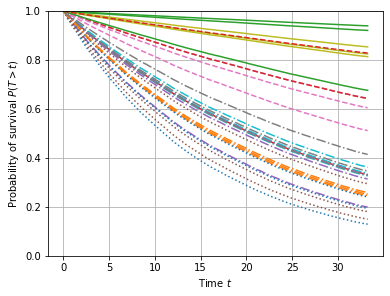

In [17]:
sample = train_test_split(x_test, y_test, event_test, time_test,
                          test_size=30, stratify=y_test, random_state=89)
x_sample, y_sample, event_sample, time_sample = sample[1::2]

sample_pred_ds = tf.data.Dataset.from_tensor_slices(
    x_sample[..., np.newaxis]).batch(64)
sample_predictions = predictor.predict(sample_pred_ds)

sample_surv_fn = breslow.get_survival_function(sample_predictions)

plt.figure(figsize=(6, 4.5))
for surv_fn, class_label in zip(sample_surv_fn, y_sample):
    risk_group = risk_score_assignment.loc[class_label, "risk_group"]
    plt.step(surv_fn.x, surv_fn.y, where="post",
             color=f"C{class_label}", linestyle=styles[risk_group])

plt.ylim(0, 1)
plt.ylabel("Probability of survival $P(T > t)$")
plt.xlabel("Time $t$")
plt.grid()

Solid lines correspond to images that belong to risk group 0 (with lowest risk), which the model was able to learn. Samples from the group with the highest risk are shown as dotted lines. Their predicted survival functions have the steepest descent, confirming that the model correctly identified different risk groups from images.

## Conclusion

We successfully built, trained, and evaluated a convolutional neural network for survival analysis on MNIST. While MNIST is obviously not a clinical dataset, the exact same approach can be used for clinical data. For instance, [Mobadersany et al.](https://www.pnas.org/content/115/13/E2970) used the same approach to predict overall survival of patients diagnosed with brain tumors from microscopic images, and [Zhu et al.](https://scholar.google.com/scholar?cluster=3381426605939025516) applied CNNs to predict survival of lung cancer patients from pathological images.